# Testing `hera_pspec` with EoR and Point-Source Foregrounds

Lily Whitler, Bobby Pascua, Zachary Martinot, and the HERA Validation Team

## Setup and Metadata

### Abstract
(to be rewritten)

We uncalibrate noiseless observations of a sky with a $1/k^2$ EoR power spectrum and foregrounds and compute the power spectrum of visibilities with various levels of calibration applied. We uncalibrate the simulated visibilities by generating gains with `hera_sim.sigchain.gen_gains` and modifying these gains by adding random phase offsets and applying linear modulation in time. We examine the power spectra of five different sets of visibilities:
* Perfectly calibrated visibilities (direct simulation output)
* Uncalibrated visibilities (simulation output with gains applied)
* Simply calibrated visibilities (calibration with frequency-independent amplitudes and delays)
* Unsmoothed, absolutely calibrated visibilities
* Smoothed, absolutely calibrated visibilities

### Imports

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import copy
import glob

import astropy
import astropy.units as units
import h5py

import hera_cal
import hera_pspec
import pyuvdata
import uvtools

from pyuvdata import UVData, UVBeam
from hera_cal import io
from hera_pspec.data import DATA_PATH as PSPEC_DATA_PATH

### Description

Last executed: {{str(datetime.now())}}

- **Major Step Description:** Simulate visibilities of foregrounds (diffuse and point source) and for a $1/k^2$ EoR power spectrum. Simulate bandpass gains with `hera_sim` and apply the gains to the simulated visibilities, then calibrate the resulting data with `hera_cal` and extract power spectrum estimates with `hera_pspec`.
- **Minor Variation Description:** 
- **Pipelines Tested:** `redcal`, `abscal`, `smooth_cal`, `pspec`
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* ``pyuvdata``: ``v1.4.1`` (git hash unknown)
* ``hera_cal``: ``2e5dd382872f649266f334e9f3ded4fc4803f017``
* ``hera_sim``: ``b'6cd21e2684867d90c2105d4287718a97af9767c4'``
* ``hera_pspec``: ``b35a8304345165911dd1158a2104adf078d05d0f``
* ``uvtools``: ``2186a528849e0ae305175e52a72f70a76417511d``

Versions of other software used in this validation test:

* ``numpy``: v1.17.4
* ``astropy``: v4.0 (763f069058cb1ee2038fa1cfa485452ec94b726e)
* ``matplotlib``: v3.1.1

### Data

The following paths reflect the exact locations of all data used in this test:

In [24]:
data_path = "/lustre/aoc/projects/hera/Validation/"
test_path = os.path.join(data_path, 'test-1.1.0')
data_prefix = "hera_hex37_100-200MHz_HERA_dipole_"

spec_path = os.path.join(test_path, "spectra/single_file/")
spec_path_full_day = os.path.join(test_path, "spectra/full_day/")
vis_path = os.path.join(test_path, "visibilities/")
plot_path = os.path.join(test_path, "plots/")
pipeline_output_path = os.path.join(test_path, "original_analysis_data_products/")

eor_path = os.path.join(data_path, 
                        data_prefix+"beam_pow_neg2_pspec/realization_0.uvh5")
gleam_path = os.path.join(data_path, 
                          data_prefix+"full_gleam_plus_brights_v01/hera_hex37_full_gleam_plus_brights_v01.uvh5")

# Path to beam normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert os.path.exists(omegas_data_path)


for path in (eor_path, gleam_path):
    assert os.path.exists(path)

## Extra Utility Functions

In [25]:
# function for saving figures
def save_fig(fig, save_path):
    if isinstance(save_path, (list, tuple)):
        for path in save_path:
            fig.savefig(path)
    else:
        fig.savefig(save_path)

In [26]:
# wrapper for uvtools.plot.waterfall
def plot_gain_waterfalls(gain_dict, extent, bounds, modes, save_path=None, 
                         time_units="s", freq_units="MHz", delay_space=False):
    xlabel = "Frequency [{}]".format(freq_units) if not delay_space \
        else "Delay [{}]".format(freq_units)
    ylabel = "Time Elapsed [{}]".format(time_units)
    
    fig = plt.figure(figsize=(14,8))
    axes = fig.subplots(2,3)
    for j, ax in enumerate(axes.ravel()):
        gain_type = list(gain_dict.keys())[j % 3]
        plot_type = ("Amplitude", "Phase")[j // 3]
        mode = modes[j // 3]
        cmap = "viridis" if j // 3 == 0 else "twilight"
        mx = bounds[j // 3][1]
        drng = None if mx is None else bounds[j // 3][1] - bounds[j // 3][0]
        
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title("{} Gain {}".format(gain_type, plot_type), fontsize=12)
        
        fig.sca(ax)
        cax = uvtools.plot.waterfall(gain_dict[gain_type], mode=mode, extent=extent,
                                     mx=mx, drng=drng, cmap=cmap)
        
        fig.colorbar(cax, label=plot_type)
        
    plt.tight_layout()
    plt.show()
    
    if save_path is not None:
        save_fig(fig, save_path)

In [27]:
# function for plotting gain differences
def plot_gain_diffs(gain_dict, extent, save_path=None, time_units="s"):
    gain_diffs = {}
    gain_types = list(gain_dict.keys())
    # fill the gain_diffs dictionary with tuples of amplitude and phase differences
    for j, gain_type in enumerate(gain_types[:-1]):
        for _gain_type in gain_types[j+1:]:
            gains = gain_dict[gain_type]
            _gains = gain_dict[_gain_type]
            diff_type = " - ".join((gain_type, _gain_type))
            amplitude_diff = np.abs(gains) - np.abs(_gains)
            phase_diff = np.angle(gains) - np.angle(_gains)
            gain_diffs[diff_type] = (amplitude_diff, phase_diff)
            
    # make the figure and axes objects, assuming we're just comparing true, abs, and smoothed abs
    fig = plt.figure(figsize=(14,8))
    axes = fig.subplots(2,3)
    for j, ax in enumerate(axes.ravel()):
        diff_type = list(gain_diffs.keys())[j % 3]
        plot_type= ("Amplitude", "Phase")[j // 3]
        
        ax.set_xlabel("Frequency [MHz]", fontsize=12)
        ax.set_ylabel("Time Elapsed [{}]".format(time_units), fontsize=12)
        ax.set_title("{} Diff: {}".format(plot_type, diff_type), fontsize=12)
        
        # choose the axis to plot on, and plot the waterfall (letting the function choose the bounds)
        fig.sca(ax)
        cax = uvtools.plot.waterfall(gain_diffs[diff_type][j // 3], mode="real", extent=extent)
        
        fig.colorbar(cax, label=plot_type)
        
    plt.tight_layout()
    plt.show()
    
    if save_path is not None:
        save_fig(fig, save_path)

In [28]:
# function for plotting gain differences at a single time
def plot_gain_diffs_1d(gain_dict, freq_array, time_array, save_path=None, time_units="s"):
    gain_diffs = {}
    gain_types = list(gain_dict.keys())
    # same deal as in above function
    for j, gain_type in enumerate(gain_types[:-1]):
        for _gain_type in gain_types[j+1:]:
            gains = gain_dict[gain_type]
            _gains = gain_dict[_gain_type]
            diff_type = " - ".join((gain_type, _gain_type))
            amplitude_diff = np.abs(gains) - np.abs(_gains)
            phase_diff = np.angle(gains) - np.angle(_gains)
            gain_diffs[diff_type] = (amplitude_diff, phase_diff)
            
    time_index = np.random.randint(0,len(time_array))
    time_value = time_array[time_index]
    
    # basically the same as above function
    fig = plt.figure(figsize=(14,8))
    axes = fig.subplots(2,3)
    for j, ax in enumerate(axes.ravel()):
        diff_type = list(gain_diffs.keys())[j % 3]
        plot_type= ("Amplitude", "Phase")[j // 3]
        
        ax.set_xlabel("Frequency [MHz]", fontsize=12)
        ax.set_ylabel(plot_type, fontsize=12)
        ax.set_title("{} Diff: {}\n at t = {:.2f} {}".format(plot_type, diff_type, time_value, time_units),
                     fontsize=12)
        
        plot_values = gain_diffs[diff_type][j // 3][time_index]
        ax.plot(freq_array, plot_values, color='k')
        
    plt.tight_layout()
    plt.show()
    if save_path is not None:
        save_fig(fig, save_path)

In [29]:
def est_mem_use(Ntimes, Nfreq, Nants, Npols, autos):
    Nbls = Nants * (Nants + 1) / 2 if autos \
      else Nants * (Nants - 1) / 2
    Nblts = Nbls * Ntimes
    sizes = {}
    sizes['data'] = Nblts * Nfreq * Npols * 16.0 # bytes
    sizes['times'] = 2 * Nblts * 8.0 # LST and time arrays
    sizes['freqs'] = Nfreq * 8.0 # frequency array
    sizes['flags'] = Nblts * Nfreq * Npols * 1.0 # flag array
    sizes['ants'] = 2 * Nants * 4.0 + 3 * Nants * 8.0 # antenna arrays + antpos array
    sizes['bls'] = Nblts * 8.0 # baseline array
    sizes['nsample'] = Nblts * Nfreq * Npols * 8.0 # nsample array
    sizes['uvw'] = 3 * Nblts * 8.0 # uvw array
    mem_use = {'data': sizes['data']}
    total_mem_use = 0
    for mem in sizes.values():
        total_mem_use += mem
    mem_use['meta'] = total_mem_use - sizes['data']
    mem_use['total'] = total_mem_use
    return mem_use

In [30]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

In [31]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path, flag_nchan_low=50, flag_nchan_high=50):
    # choose only data that hasn't been flagged, assuming 1024 frequency channels
    chans = np.arange(1024)[flag_nchan_low:-flag_nchan_high]
    
    uvd = UVData()
    uvd.read_uvh5(vis_data_path, freq_chans=chans, keep_all_metadata=False)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [32]:
# function for computing the aliased power spectrum; see test 0.2.0 notebook
def aliased_power_spectrum(k, ks, z, freq_dep=False, cosmo=None):
    # power spectrum amplitude
    A0 = 10 * (1.0/0.2)**-2 # K^2 Mpc
    
    if cosmo is not None:
        # assume k, ks in little_h units, use mK instead of K
        A0 *= 1e6 * cosmo.h
        
    Pk = A0 * np.pi**2 / (2 * ks * np.sin(np.pi * k / (2 * ks)))**2 # K^2 Mpc^3
    # above units are correct as long as k is in units of 1/Mpc
    
    Pk /= (1+z)**2
    if freq_dep:
        # assume we're working with the power spectrum w/ frequency-scaled amplitude
        # so follow the steps in the 0.2.0 notebook
        
        # frequency of HI line at the source
        f21_emit = 1420.4057517667 # MHz
        
        # redshifted 21-cm line
        f21_obs = f21_emit/(1 + z)
        
        # scale the power spectrum by an overall factor of 100 at 100 MHz
        # also put in the freq scaling
        Pk *= 100 * (100 / f21_obs)**6

    return Pk

In [33]:
# get delay spectrum of a waterfall
def delay_xform(data):
    """Return the delay transform of the input data.
    
    Assumes frequency axis is the last axis of the array.
    
    """
    return np.fft.fftshift(np.fft.fft(data, axis=1), axes=1)

## Data Reading

Data created with /lustre/aoc/projects/hera/Validation/test-1.1.0/prepare_data.py

More description to come

In [34]:
single_file_path = sorted(glob.glob(os.path.join(vis_path, 'zen.*.RR.true.uvh5')))[1]
hd_single_file = io.HERAData(single_file_path)
hd_single_file.read(return_data=False)

Telescope RIMEz calculation is not in known_telescopes.


In [35]:
times = np.unique(hd_single_file.time_array)
lsts = np.unique(hd_single_file.lst_array)
freqs = np.unique(hd_single_file.freq_array)

In [36]:
eor_single_file = sorted(glob.glob('/lustre/aoc/projects/hera/Validation/test-2.1.0/' +
                                   'visibilities/full_day/zen.*.RR.eor.uvh5'))[1]
hd_eor = io.HERAData(eor_single_file)
hd_eor.read(return_data=False)

## Power Spectra

In this section, we inspect the power spectrum estimates for the "single file" set of data.

In [37]:
# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies (all should be unflagged since we did nothing with hera_cal, xrfi, etc.)
freq_slice = slice(None)

# load beam-dependent normalization data
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()][freq_slice]
    Omegapp = h5f['Omegapp'][()][freq_slice]

beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, freqs[freq_slice], cosmo=cosmo)

# wrapper for pspec_run
def calc_pspec(vis_file, outfile, spw_ranges=None, blpairs=None):
    uvdI = get_VI_data(vis_file)
    _ = hera_pspec.pspecdata.pspec_run([uvdI], outfile, dset_pairs=[(0, 0)], file_type="uvh5",
                                       taper="blackman-harris", beam=beam, cosmo=cosmo,
                                       spw_ranges=spw_ranges, blpairs=blpairs, pol_pairs=[('pI','pI')],
                                       Jy2mK=True, exclude_cross_bls=True, 
                                       overwrite=True, verbose=True)

In [38]:
%%time
spec_path_temp = '/users/lwhitler/lustre/validation/test-1.1.0_pspecs'
vis_files = [eor_single_file, single_file_path]
eor_pspec = os.path.join(spec_path_temp, "eor_single_file_pspec.psc")
eor_fg_pspec = os.path.join(spec_path_temp, "single_file_pspec.psc")
pspec_files = [eor_pspec, eor_fg_pspec]

spws = [(400, 600)]
blps = [((0,1), (0,1)), ((0,15), (0,15)), ((0,32), (0,32))]

for vis_file, pspec_file in zip(vis_files, pspec_files):
    print("Extracting spectrum from {}".format(os.path.basename(vis_file)))
    calc_pspec(vis_file, pspec_file, spws, blps)

Extracting spectrum from zen.2451545.16236.RR.eor.uvh5
Opening /users/lwhitler/lustre/validation/test-1.1.0_pspecs/eor_single_file_pspec.psc in transactional mode

Setting spectral range: (400, 600)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 1), (0, 1))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 15), (0, 15))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 32), (0, 32))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...
Storing dset0_x_dset0
Extracting spectrum from zen.2451545.16918.RR.true.uvh5
Opening /users/lwhitler/lustre/validation/test-1.1.0_pspecs/single_file_pspec.psc in transactional mode
CPU times: user 56.3 s, sys: 1.93 s, total: 58.3 s
Wall time: 22.7 s


In [39]:
def get_pspec(pspec_file):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    return uvp

In [53]:
def get_k_nyquist(uvp_avg, spw=0):
    keys = uvp_avg.get_all_keys()
    dly = uvp_avg.get_dlys(spw)
    
    if dly.size % 2 == 0:
        tau_nyquist = np.amax(dly)
    else:
        ddly = np.diff(dly)[0]
        tau_nyquist = np.amax(dly) + ddly/2.

    spw_freqs = uvp_avg.freq_array[uvp_avg.spw_freq_array == spw]
    z_mean = uvp_avg.cosmo.f2z(np.mean(spw_freqs))

    return np.amax(tau_nyquist)*uvp_avg.cosmo.tau_to_kpara(z_mean, little_h=False)

In [41]:
def aliased_power_spectrum(k, k_nyquist):
    A0 = 1e1 * (1./0.2)**-2.
    Pk = 1e6 * A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k /(2*k_nyquist)))**2
    return Pk

In [42]:
uvps, uvp_avgs = [], []
for pspec_file in pspec_files:
    uvp_temp = get_pspec(pspec_file)
    blpair_group = [[blp] for blp in np.unique(uvp_temp.blpair_array)]
    uvp_avg_temp = uvp_temp.average_spectra(blpair_groups=blpair_group, time_avg=True, inplace=False)
    uvp_avg_temp.fold_spectra()
    
    uvps.append(uvp_temp)
    uvp_avgs.append(uvp_avg_temp)

In [74]:
def plot_spectra(uvp_avgs, labels, blps, spws=[0], polpair=('pI', 'pI'),
                 fig=None, ax=None, linestyles=None, colors=None, alpha=0.5,
                 figsize=(10, 7)):
    # Expects a list of averaged uvps and the label/name of each
    assert len(uvp_avgs) == len(labels)
    
    # Set up defaults for plotting
    if linestyles is None:
        linestyles = ['-'] * len(uvp_avgs)
    if colors is None:
        colors = ['k'] * len(uvp_avgs)
    
    ax_arg = True
    if ax is None:
        fig, ax = plt.subplots(len(blps), len(spws), sharex='col', sharey='row', figsize=figsize)
        ax_arg = False
        
    #     ms = 8 if label=="true" else 6
    #     alpha = 0.3 if label=="true" else 0.65
    #     lw = 6 if label=="true" else 2
        
    # This is kind of weird indexing... should the gridding of the subplots be the other way around?
    # (spws = rows and blps = columns?)
    for i in range(len(blps)):
        for j in range(len(spws)):
            key = (spws[j], blps[i], polpair)
            k_paras = uvp_avgs[0].get_kparas(spws[j])  # This assumes that all uvps in uvp_avgs have the same
                                                      # kparas, which I think is a reasonable assumption...
            k_nyquist = get_k_nyquist(uvp_avgs[0], spw=spws[j])
            analytic_spectrum = aliased_power_spectrum(k_paras, k_nyquist)
                        
            # Set up for plotting
            # Deal with cases when there is only one subplot, one spw, or one baseline pair
            # First make sure that if there was an axis passed, we use it
            if ax_arg:
                ax_plot = ax
            # Otherwise, deal with the cases of only having one subplot, one row, and/or one column
            else:
                if len(fig.get_axes()) == 1:
                    ax_plot = ax
                elif len(blps) == 1:
                    ax_plot = ax[j]
                elif len(spws) == 1:
                    ax_plot = ax[i]
                else:
                    ax_plot = ax[i, j]
            
            # Actually plot the spectra
            ax_plot.loglog(k_paras, np.abs(analytic_spectrum), ls='-', color='k', label='analytic')
            for k in range(len(uvp_avgs)):
                uvp_plot = uvp_avgs[k].get_data(key)
                ax_plot.loglog(k_paras, np.abs(uvp_plot[0]), ls=linestyles[k], color=colors[k],
                               alpha=alpha, label=labels[k])

            ax_plot.set_xlabel(r'$k_\parallel$ [$h$ Mpc$^{-1}$]', fontsize=12)
            ax_plot.set_ylabel(r'Power [mK$^2$ $h^{-3}$ Mpc$^3$]', fontsize=12)
            ax_plot.set_title('spw: {}; blp: {}; pol: {}'.format(key[0], key[1], key[2]),
                              fontsize=12)

            ax_plot.set_xlim(0.4, k_paras.max())
            ax_plot.set_ylim(10, 1e7)
            ax_plot.legend()

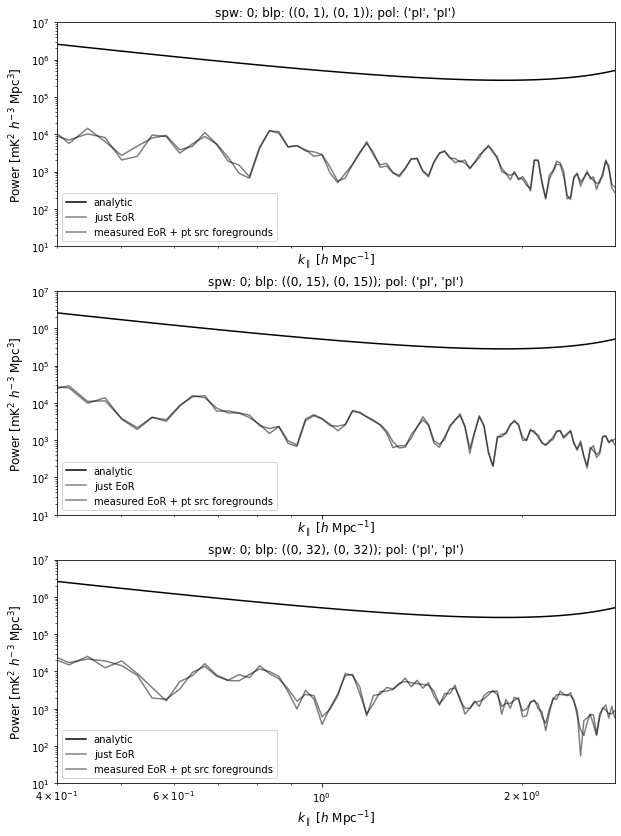

In [78]:
labels = ['just EoR', 'measured EoR + pt src foregrounds']
plot_spectra(uvp_avgs, labels, blps, figsize=(10, 14))

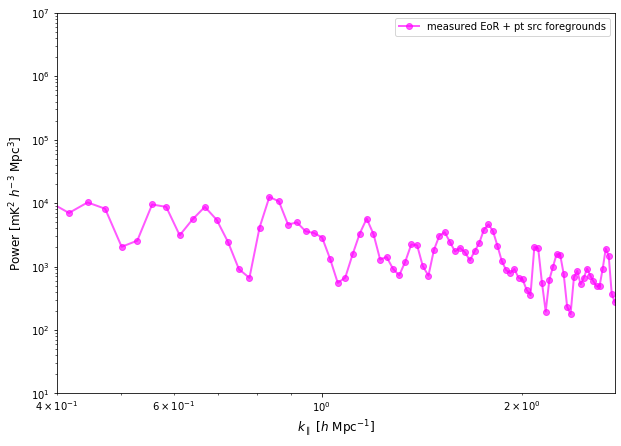

In [35]:
# labels = ['analytic', 'measured EoR + pt src foregrounds']
# colors = ["magenta", "gray", "forestgreen", "dodgerblue", "darkred", "gold"]
# markers = ["o", "s", "*", "p", "h", "D"]
# linestyles = ["-", "-", "-", "-", "--", ":"]
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111)
# ax.set_xlabel("$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
# ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
# # ax.set_title("One Spectra\nspw: {}; blp: {}; pol: {}".format(spws[key[0]], key[1], key[2]), fontsize=12)

# ax.set_xlim(0.4, kparas[0].max())
# ax.set_ylim(10, 10**7)

# for j, label in enumerate(labels):
#     if label in ("simple", "uncal"):
#         pass
#     ms = 8 if label=="true" else 6
#     alpha = 0.3 if label=="true" else 0.65
#     lw = 6 if label=="true" else 2
#     ax.loglog(kparas[j], np.abs(spectra[j]), lw=lw, marker=markers[j], ms=ms, 
#               label=label, color=colors[j], ls=linestyles[j], alpha=alpha)
# ax.legend()
# plt.show()
# plot_save_path = "/lustre/aoc/projects/hera/Validation/test-1.1.0/plots/single_file_pspec.pdf"
# # fig.savefig(plot_save_path)

**Figure 6 |** Power spectrum estimates from various visibility data sets for a "single file" worth of data (60 integrations). It is somewhat difficult to tell, but the smoothed abscal results seem to exactly agree with the unsmoothed abscal results. Somewhat easier to see is the high level of agreement between the power spectrum estimates from the absolutely calibrated visibilities and the true visibilities.

## Full Day Results

In this section, we examine the resulting power spectra from performing the above analysis on a data set spanning 8 hours. Python scripts for all of the data preparation and analysis can be found in the following directory on the NRAO server: `/lustre/aoc/projects/hera/Validation/test-2.1.0/` (see the scripts with `_multiprocessing` in their names for power spectrum retrieval; see the `preparation` scripts in the `master_data` subdirectory to see how the raw simulation files were modified to work with a modified version of the pipeline's makeflow; see the scripts in the `makeflow` subdirectory to see how the makeflow for this test was configured; finally, note that the EoR component was done separately&mdash;this was just because I forgot to set up the EoR files the first time around). A brief summary of the test steps is as follows: 


*CORRECT FOR REMOVING GSM LATER*

Visibilities were simulated for 24 hours over the full HERA H1C bandwidth (100 MHz - 200 MHz) over 1024 frequency channels with a uniform integration time of 10.7 seconds. Three sets of visibilities were simulated: one component is for diffuse foregrounds, simulated using the eGSM diffuse sky model; another component is for point-source visibilities, using the parameters listed in the GLEAM catalog; the final component is for the EoR signal, with a power spectrum amplitude that goes like $P(k) = A_0 k^{-2}$; each visibility component contains simulated observations for four polarizations (XX, XY, YX, YY). The simulations were carried out with the `RIMEz` simulation package, using the HERA dipole beam model. The individual visibility files were added together to form the "true" sky model, but only the first eight hours of the simulated data were used for this test. Finally, note that the visibility simulations are noiseless and perfectly calibrated. 
 
The true visibilities were uncalibrated using simulated gains. The gains were simulated on a per-antenna basis using the `gen_gains` function found in the `hera_sim.sigchain` module for each linear polarization. Additionally, each antenna gain was assigned a constant phase offset and had its amplitude vary linearly by 10 percent over eight hours. 
 
The uncalibrated visibilities were pushed through the analysis pipeline using a modified version of the IDR2.2 makeflow (except for the RFI flagging step, since there is no RFI in the simulated data)&mdash;part of this test is to validate the performance of the (post-redundant calibration) absolute calibration step and the calibration smoothing step. The absolute calibration solutions were smoothed in time and frequency using a Tukey window with $\alpha = 0.3$; the solutions were smoothed on a 10 MHz frequency scale and a 4 hour time scale. In addition to absolute calibration, we performed a simple calibration in this test by modifying the absolutely-calibrated gain solutions to have a frequency-independent amplitude and delay.  
 
The power spectrum estimates were obtained using the `pspec_run` function in the `hera_pspec.pspecdata` module. This test used six spectral windows over the full bandwidth (except for the first and last 50 channels, which were flagged for the redundant calibration step) and a Blackman-Harris taper for calculating the power spectrum estimates. We obtained power spectrum estimates for seven sets of visibilities: perfectly calibrated (true), uncalibrated, redundantly calibrated, absolutely calibrated, absolutely calibrated with time and frequency smoothing, simply calibrated, and EoR-only. We present the results on a per-spectral-window basis, showing both a scatter plot of power spectrum estimates on a per-baseline basis, as well as a line plot that has been averaged over all baselines. Each power spectrum presented has been incoherently averaged over the full eight hours.

In [96]:
# load in the true gains
true_gain_file = os.path.join(plot_path.replace("plots","master_data"), "true_gains.npy")
assert os.path.exists(true_gain_file)
true_gains = np.load(true_gain_file, allow_pickle=True)[None][0]

In [97]:
# get the times and frequencies for plotting

# first, get a glob of visibility files, there should be 269 for each type of calibration
vis_files = sorted(glob.glob(os.path.join(pipeline_output_path, "*.uncal.uvh5")))
assert len(vis_files) == 269

# now load in the first one to get the initial time and the frequencies
times = []
for vis_file in vis_files:
    uvd = UVData()
    uvd.read_uvh5(vis_file)
    times.append(np.unique(uvd.time_array))

times = np.array(times)
times = times.reshape(times.size)
freqs = uvd.freq_array[0][flag_nchan_low:-flag_nchan_high]/1e6 # MHz

# don't need the UVData object anymore
del uvd

# now make the extent for the waterfall plots
extent = [freqs.min(), freqs.max(), (times[-1]-times[0])*units.day.to("hr"), 0]

Telescope RIMEz calculation is not in known_telescopes.


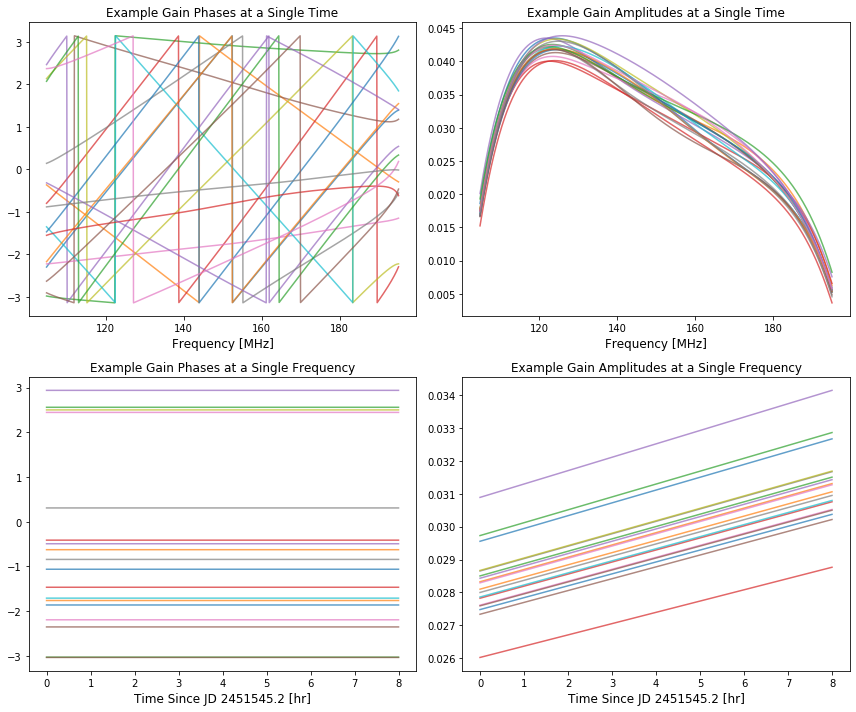

In [98]:
# take a peek at some of the gains
fig = plt.figure(figsize=(12,10))
axes = fig.subplots(2,2)

axes[0,0].set_title("Example Gain Phases at a Single Time", fontsize=12)
axes[0,1].set_title("Example Gain Amplitudes at a Single Time", fontsize=12)
axes[1,0].set_title("Example Gain Phases at a Single Frequency", fontsize=12)
axes[1,1].set_title("Example Gain Amplitudes at a Single Frequency", fontsize=12)

for ax in axes[0]:
    ax.set_xlabel("Frequency [MHz]", fontsize=12)
for ax in axes[1]:
    ax.set_xlabel("Time Since JD {:8.1f} [hr]".format(times[0]), fontsize=12)

for ant in list(ants)[::4]:
    gain = true_gains[ant][no_flag]
    
    axes[0,0].plot(freqs, np.angle(gain[0]), alpha=0.7)
    axes[0,1].plot(freqs, np.abs(gain[0]), alpha=0.7)
    axes[1,0].plot((times-times[0])*units.day.to("hr"), np.angle(gain[:,37]), alpha=0.7)
    axes[1,1].plot((times-times[0])*units.day.to("hr"), np.abs(gain[:,37]), alpha=0.7)
    
plt.tight_layout()
plt.show()

**Figure 7 |** Gains for the full day. Note that the simulated gains were made to have their amplitudes vary linearly by 10 percent over the course of 8 hours (but have their phases remain constant in time).

### Calibration Results

In [99]:
abscal_glob = sorted(glob.glob(os.path.join(pipeline_output_path, "*.abs.calfits")))
smoothcal_glob = sorted(glob.glob(os.path.join(pipeline_output_path, "*.smooth_abs.calfits")))
assert len(abscal_glob) == len(smoothcal_glob) and len(abscal_glob) != 0

In [100]:
ac = io.HERACal(abscal_glob[0])
ac_gains = ac.read()[0]
ants = list(ac_gains.keys())

# no particular reason for choosing these antennas as a reference
refant = {"Jxx" : (13, "Jxx"), "Jyy" : (22, "Jyy")}

# initialize a dictionary of gains for the full day
abscal_gains = {ant : [] for ant in ants}
smoothcal_gains = {ant : [] for ant in ants}

# loop over all the abscal and smoothcal files
for abscal_file, smoothcal_file in zip(abscal_glob, smoothcal_glob):
    # instantiate HERACal objects for each file
    ac = io.HERACal(abscal_file)
    sc = io.HERACal(smoothcal_file)
    
    # load in the gains
    ac_gains = ac.read()[0]
    sc_gains = sc.read()[0]
    
    # update the gain dictionaries
    for ant in ants:
        abscal_gains[ant].append(ac_gains[ant])
        smoothcal_gains[ant].append(sc_gains[ant])

# now reshape the gain arrays
for ant in ants:
    ac_gains = np.array(abscal_gains[ant])
    sc_gains = np.array(smoothcal_gains[ant])
    
    new_shape = (ac_gains.shape[0] * ac_gains.shape[1], ac_gains.shape[2])
    abscal_gains[ant] = ac_gains.reshape(new_shape)
    smoothcal_gains[ant] = sc_gains.reshape(new_shape)
    
# now rephase the gains
abscal_gains = rephase_gains(abscal_gains, refant)
smoothcal_gains = rephase_gains(smoothcal_gains, refant)
true_gains = rephase_gains(true_gains, refant)

In [101]:
# choose an antenna to inspect
ant = ants[np.random.randint(0,len(ants))]

gain_dict = {"Abscal" : abscal_gains[ant][no_flag], 
             "True" : true_gains[ant][no_flag],
             "Smoothed Abscal" : smoothcal_gains[ant][no_flag]}

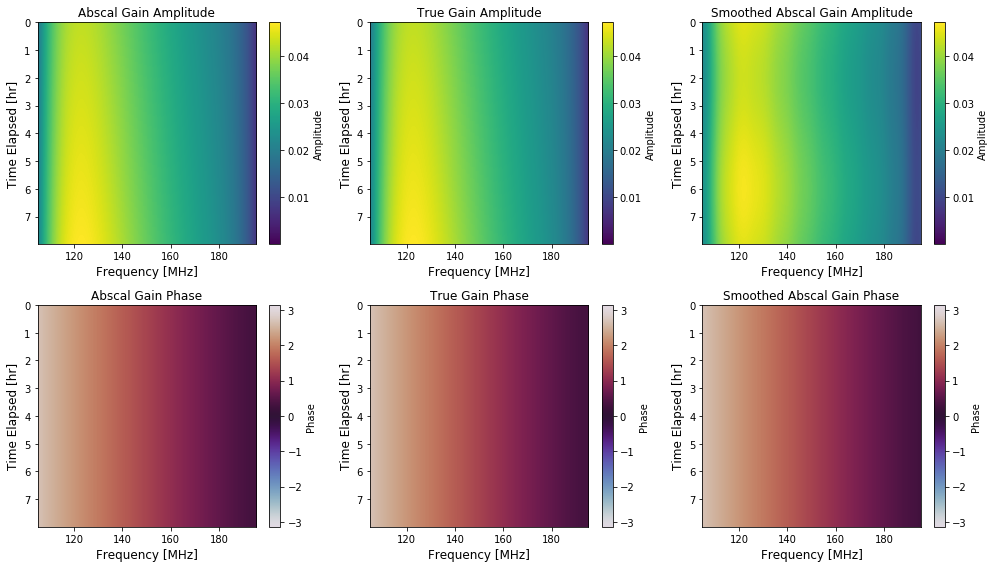

The above plots are for antenna: (24, 'Jyy')


In [102]:
# get bounds
amp_bounds = (np.abs(true_gains[ant]).min(), np.abs(true_gains[ant]).max())
phs_bounds = (-np.pi, np.pi)
bounds = (amp_bounds, phs_bounds)
modes = ("abs", "phs")

# make the plot
gain_plot_file = os.path.join(plot_path, "full_day_gains_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_plot_file, gain_plot_file.replace(".pdf",".png")]
plot_gain_waterfalls(gain_dict, extent, bounds, modes, save_path=save_paths, time_units="hr")
print("The above plots are for antenna: {}".format(ant))

**Figure 8 |** Gain amplitude and phase waterfalls for the absolutely calibrated gain solutions, the smoothed versions thereof, and the true gains.

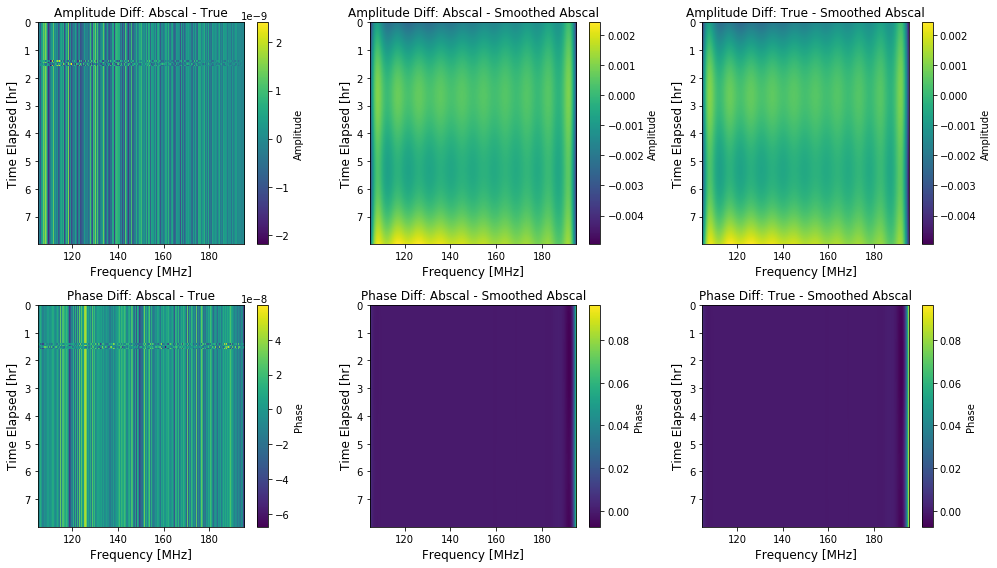

The above plots are for antenna: (24, 'Jyy')


In [103]:
# plot the diffs
gain_diff_plot_file = os.path.join(plot_path, "full_day_gain_diff_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_diff_plot_file, gain_diff_plot_file.replace(".pdf", ".png")]
plot_gain_diffs(gain_dict, extent, save_path=save_paths, time_units="hr")
print("The above plots are for antenna: {}".format(ant))

**Figure 9 |** Waterfall plots for the amplitudes and phases of the differenced sets of gains. The leftmost column shows the comparison between the abscal solutions and the smoothed solutions; the other columns show the differences with the true gains. Note that the absolutely calibrated gain solutions are correct to machine precision, but the smoothed gain solutions introduce errors up to about the 10 percent level. (Perhaps important to note is that the errors in the smoothed solutions are only at about the 2 percent level when the gains do not vary in time.)

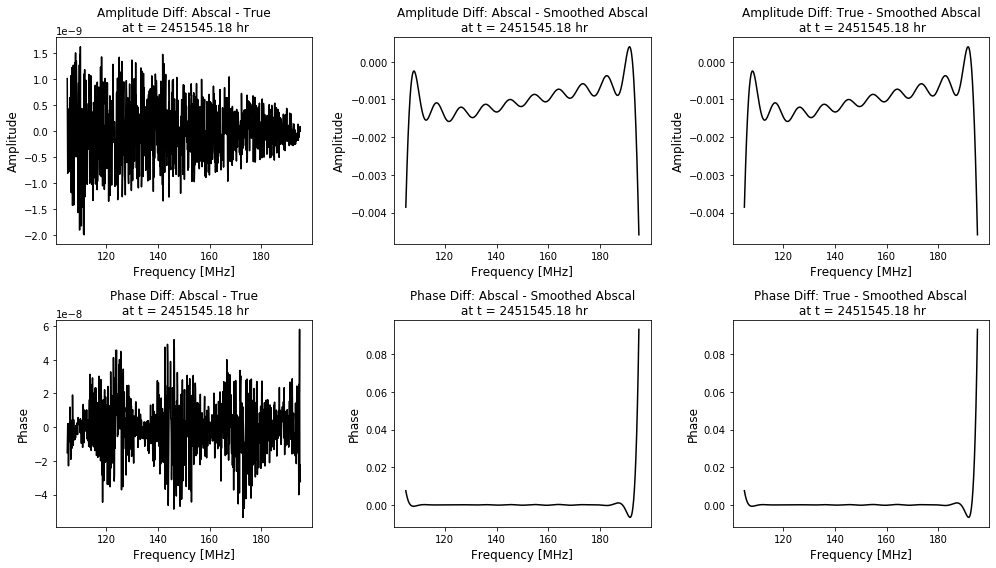

The above plots are for antenna: (24, 'Jyy')


In [104]:
# plot the diffs at a single time
gain_diff_plot_file = os.path.join(plot_path, "full_day_single_time_gain_diff_{}_{}.pdf".format(ant[0],ant[1]))
save_paths = [gain_diff_plot_file, gain_diff_plot_file.replace(".pdf", ".png")]
plot_gain_diffs_1d(gain_dict, freqs, times, save_path=save_paths, time_units="hr")
print("The above plots are for antenna: {}".format(ant))

**Figure 10 |** Same plots as above, but at a single time.

In [112]:
# get the delay spectrum for each antenna's gain
gain_labels = tuple(gain_dict.keys())
gain_delay_xforms = {
    gain_label : {
        ant : delay_xform(np.abs(gain_waterfall[no_flag])).mean(axis=0)
        for ant, gain_waterfall in gains.items()
    } for gain_label, gains in zip(gain_labels, (abscal_gains, true_gains, smoothcal_gains)) 
}

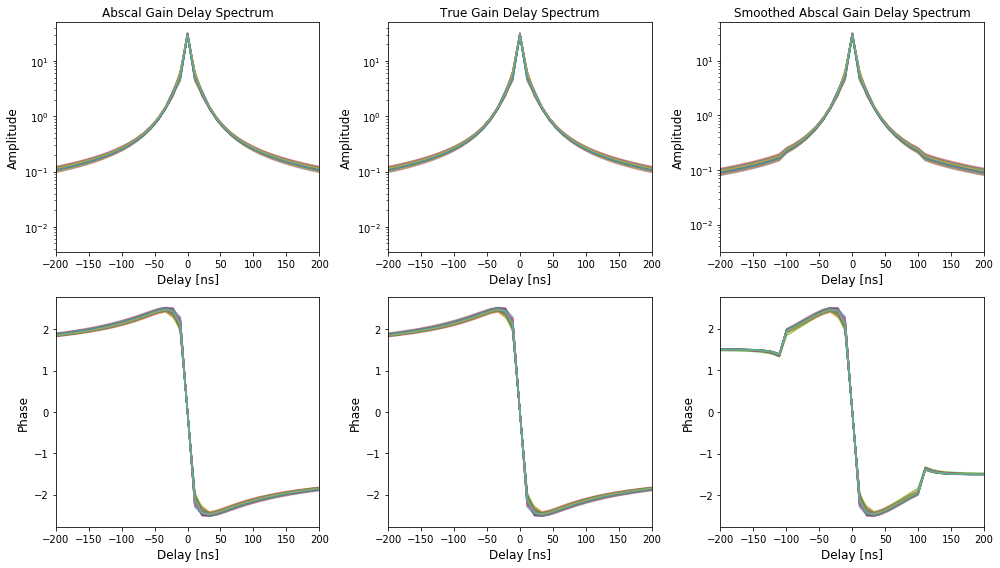

In [113]:
dlys = hera_pspec.utils.get_delays(freqs) * 1e3 # ns
dly_cut = 200 # ns

# for each set of gain solutions, plot the delay spectra amplitudes/phases
fig = plt.figure(figsize=(14,8))
axes = fig.subplots(2,3)
for i, ax in enumerate(axes.ravel()):
    gain_label = gain_labels[i % 3]
    gains = gain_delay_xforms[gain_label]
    label = "%s Gain Delay Spectrum" % gain_label
    if i < 3:
        ax.set_title(label, fontsize=12)
        ax.set_yscale('log')
    ylabel = ("Amplitude", "Phase")[i // 3]
    ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlim(-dly_cut, dly_cut)
    for gain in gains.values():
        gain = np.abs(gain) if i < 3 else np.angle(gain)
        ax.plot(dlys, gain, alpha=0.6)
plt.tight_layout()
plt.show()

In [121]:
# get the delay transform of the ratio true:est
del gain_delay_xforms
gain_labels = ("True/Abscal", "True/Smoothcal")
gain_ratios_dly = {
    gain_label : {
        ant : delay_xform(true_gains[ant][no_flag]/est_gains[no_flag]).mean(axis=0)
        for ant, est_gains in gains.items()
    } for gain_label, gains in zip(gain_labels, (abscal_gains, smoothcal_gains))
}

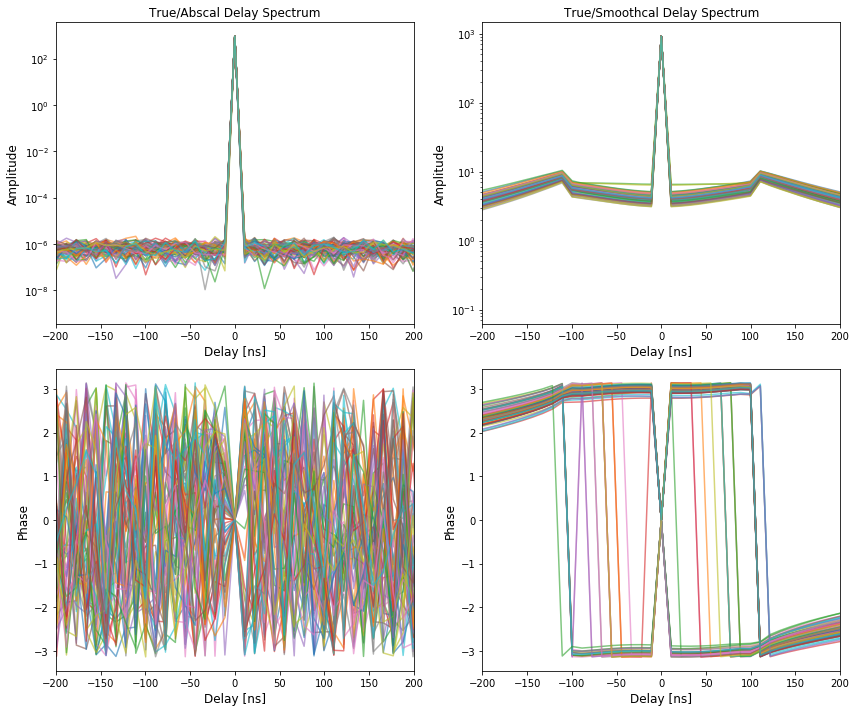

In [122]:
dly_cut = 200 # ns

fig = plt.figure(figsize=(12,10))
axes = fig.subplots(2,2)
for i, ax in enumerate(axes.ravel()):
    label = gain_labels[i % 2]
    ylabel = ("Amplitude", "Phase")[i // 2]
    if i < 2:
        ax.set_yscale('log')
        ax.set_title("%s Delay Spectrum" % label, fontsize=12)
    ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlim(-dly_cut, dly_cut)
    for gain_ratio in gain_ratios_dly[label].values():
        ratio = np.abs(gain_ratio) if i < 2 else np.angle(gain_ratio)
        ax.plot(dlys, ratio, alpha=0.6)
        
plt.tight_layout()
plt.show()

In [50]:
# just to be safe, delete the gains
del gain_dict, abscal_gains, smoothcal_gains, true_gains, gain_ratios_dly

### Inspection of Visibility Solutions

In [51]:
cal_vis_path = os.path.join(data_path, "test-2.1.0/2451545")
full_day_vis_path = os.path.join(data_path, "test-2.1.0/visibilities/full_day")
true_vis_glob = sorted(glob.glob(os.path.join(full_day_vis_path, "*.RR.true.uvh5")))
abs_vis_glob = sorted(glob.glob(os.path.join(cal_vis_path, "*.abs_vis.uvh5")))
smooth_vis_glob = sorted(glob.glob(os.path.join(cal_vis_path, "*.smooth_abs_vis.uvh5")))
assert len(abs_vis_glob) == len(smooth_vis_glob) and len(abs_vis_glob) != 0
assert len(abs_vis_glob) == len(true_vis_glob)

In [52]:
%%time
# reading in all of the files would require too much memory
Nfiles = int(len(abs_vis_glob) / 4)

# do the abs vis first because it's already compressed by redundancy
abs_vis_uvd = UVData()
abs_vis_uvd.read(abs_vis_glob[:Nfiles])

# choose the bls
bls_to_use = sorted(list(set(
    [abs_vis_uvd.baseline_to_antnums(bl) for bl in abs_vis_uvd.baseline_array]
)))
true_vis_uvd = UVData()
true_vis_uvd.read(true_vis_glob[:Nfiles], bls=bls_to_use, keep_all_metadata=False)

Telescope RIMEz calculation is not in known_telescopes.


CPU times: user 12min 47s, sys: 1min 40s, total: 14min 28s
Wall time: 10min 57s


invalid value encountered in less_equal


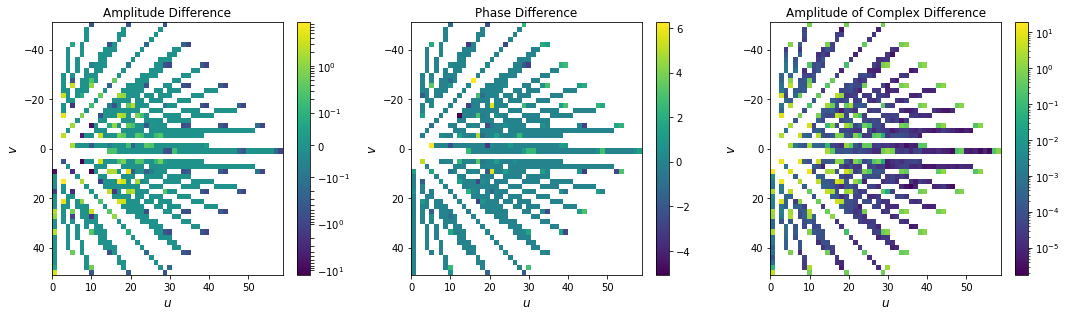

In [53]:
# compare abs and true
abs_vis_uvd = UVData()
abs_vis_uvd.read(abs_vis_glob[:Nfiles])
# check out how the visibilities compare in the uv-plane
fig = uvtools.plot.plot_diff_uv(true_vis_uvd, abs_vis_uvd)
plt.tight_layout()
plt.show()

In [54]:
np.median(np.abs(true_vis_uvd.data_array))

4.879924976152079

In [55]:
np.median(np.abs(abs_vis_uvd.data_array))

9.952557235932016

In [56]:
np.mean(np.abs(true_vis_uvd.data_array))

9.59864012384293

In [57]:
np.mean(np.abs(abs_vis_uvd.data_array))

13.984345539845101

In [58]:
del abs_vis_uvd, true_vis_uvd

### Power Spectrum Results

In this section, we load and visualize the power spectrum estimations for every data set for the full eight hours investigated in this test.

In [59]:
simple_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.RR.uncal.simple_vis.psc")))
abs_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.RR.uncal.abs_vis.psc")))
smooth_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.RR.uncal.smooth*.psc")))
uncal_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.RR.uncal.psc")))
omni_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.RR.uncal.omni*.psc")))
true_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.RR.true.psc")))
eor_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.eor.psc")))
fg_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.fg_only.psc")))

In [60]:
globs = (simple_spec_glob, abs_spec_glob, smooth_spec_glob, uncal_spec_glob, 
         omni_spec_glob, true_spec_glob, eor_spec_glob, fg_spec_glob)

In [61]:
for spec_glob in globs:
    print(len(spec_glob))

269
269
269
269
269
269
269
269


In [62]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

# initialize some dictionaries
simple_cal_spectra = {spw: {} for spw in range(6)}
abs_cal_spectra = {spw: {} for spw in range(6)}
smooth_abs_cal_spectra = {spw: {} for spw in range(6)}
omni_cal_spectra = {spw: {} for spw in range(6)}
uncal_spectra = {spw: {} for spw in range(6)}
true_spectra = {spw: {} for spw in range(6)}
eor_spectra = {spw: {} for spw in range(6)}
fg_spectra = {spw: {} for spw in range(6)}

# some stuff for making things easy
spectra = {"simple" : simple_cal_spectra,
           "abs" : abs_cal_spectra,
           "smooth" : smooth_abs_cal_spectra, 
           "uncal" : uncal_spectra,
           "omni" : omni_cal_spectra,
           "true" : true_spectra,
           "eor" : eor_spectra,
           "fg" : fg_spectra}

labels = tuple(spectra.keys())
assert len(labels) == len(globs)

skip_data = ("uncal", "omni")

for label, spec_glob in zip(labels, globs):
    if label in skip_data:
        continue
    spec_by_spw = spectra[label]
    for spec_file in spec_glob:
        psc = hera_pspec.container.PSpecContainer(spec_file, keep_open=False)
        uvp = psc.get_pspec(psc.groups()[0])[0]
        uvp.fold_spectra()
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            try:
                spec_by_spw[spw][blp].append(uvp.get_data(key))
            except KeyError:
                spec_by_spw[spw][blp] = [uvp.get_data(key),]
        
del psc, uvp

CPU times: user 12min, sys: 3min 52s, total: 15min 53s
Wall time: 30min 37s


In [63]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (10, 76)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spw in spec_dict.keys():
        for blp in spec_dict[spw].keys():
            for spec in spec_dict[spw][blp]:
                assert spec.shape == (10,76)
                
# now let's re-shape from (Nfiles, Ntimes, Ndlys) to (Nfiles * Ntimes, Ndlys)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spec_by_spw in spec_dict.values():
        for blp, spec in spec_by_spw.items():
            spec = np.array(spec)
            new_shape = (spec.shape[0] * spec.shape[1], spec.shape[2])
            spec_by_spw[blp] = spec.reshape(new_shape)
            
# in the end we have an array of shape (Nspw, Nblps, Nfiles * Ntimes, Ndlys)

In [64]:
# get the spectral window edges, k_parallel values, and delays
psc = hera_pspec.container.PSpecContainer(smooth_spec_glob[0], keep_open=False)
uvp = psc.get_pspec(psc.groups()[0])[0]
uvp.fold_spectra()
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(6)]
dlys = [uvp.get_dlys(j) for j in range(6)]

# now get the expected power spectrum for each spectral window
aliased_spectra = {}
for j, kparas in enumerate(k_paras):
    # get the frequencies in the spectral window
    spw = uvp.freq_array[j*154 : (j+1)*154] # 154 channels per spectral window
    
    # get redshift at band-center
    z = cosmo.f2z(np.mean(spw))
    
    # get co-moving distances sampled along LoS
    sampled_distances = np.array([cosmo.DC(z) for z in cosmo.f2z(spw)])
    
    # convert to approximate sampling frequency
    ks_est = np.pi/np.mean(np.abs(np.diff(sampled_distances)))

    # calculate aliased power spectrum
    aliased_spectra[j] = aliased_power_spectrum(kparas, ks_est, z, cosmo=cosmo)
    
del psc, uvp

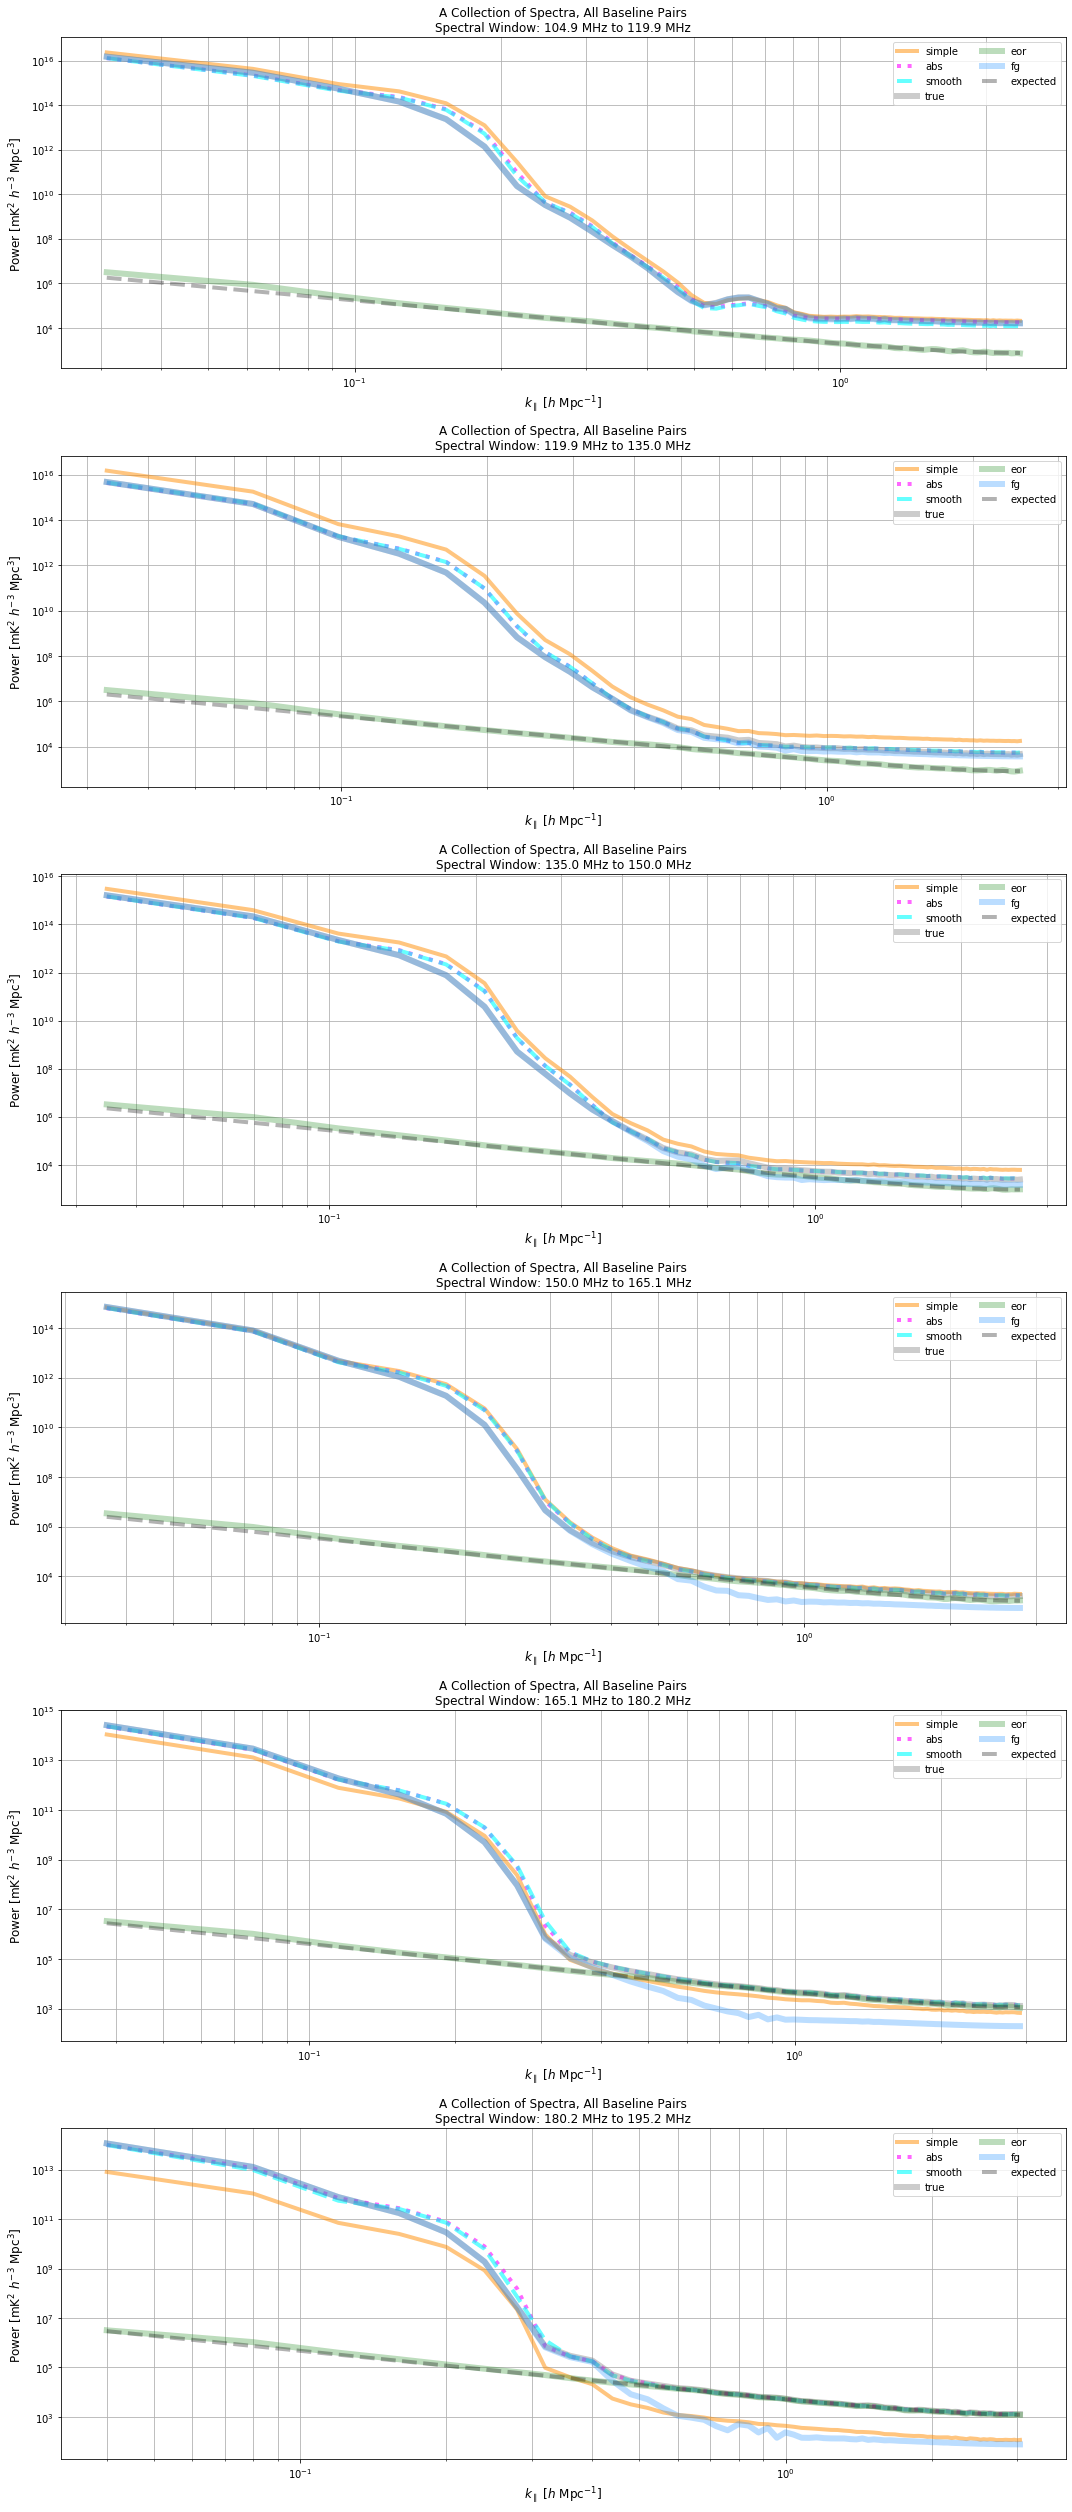

In [65]:
# for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
labels = ("simple", "abs", "smooth", "true", "eor", "fg")
spec_to_plot = {label : spectra[label] for label in labels}
colors = ("darkorange", "magenta", "cyan", "gray", "forestgreen", "dodgerblue")
alphas = (0.5, 0.6, 0.6, 0.4, 0.3, 0.3)
linestyles = ('-', ':', '--', '-', '-', '-')
lws = (4, 4, 4, 6, 6, 6)

# bundle these up into a tuple of things to be iterated over
plot_iterator = lambda : zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws)

# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    #ax.set_xlim(0.4, k_paras[j].max())
    #ax.set_ylim(10**2.75, 10**5.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for spec in spec_by_spw.values():
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.asarray(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_all_kparas.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 11 |** Power spectra for the six spectral windows used in this analysis. Only auto-baseline pairs were used for power spectrum estimation. Each line notes the power spectrum estimate, incoherently averaged in time over the full eight hours of simulated data used and averaged over all baseline pairs. Note that the extent of foreground leakage appears to depend on choice of spectral window&mdash;we only see EoR dominate the signal at some $k$-modes in the last two spectral windows.

Note that the power spectrum estimates for the absolutely calibrated visibilities and the smoothed versions thereof tend to deviate toward the band edges (the first and last spectral windows), but are nearly identical for the middle spectral windows. A curious feature worth noting is that the power spectrum estimation for a given $k_\parallel$ mode is different between spectral windows; it is suspected that this is a consequence of the choice of windowing function and the relative amplitude of the foreground power and EoR power.

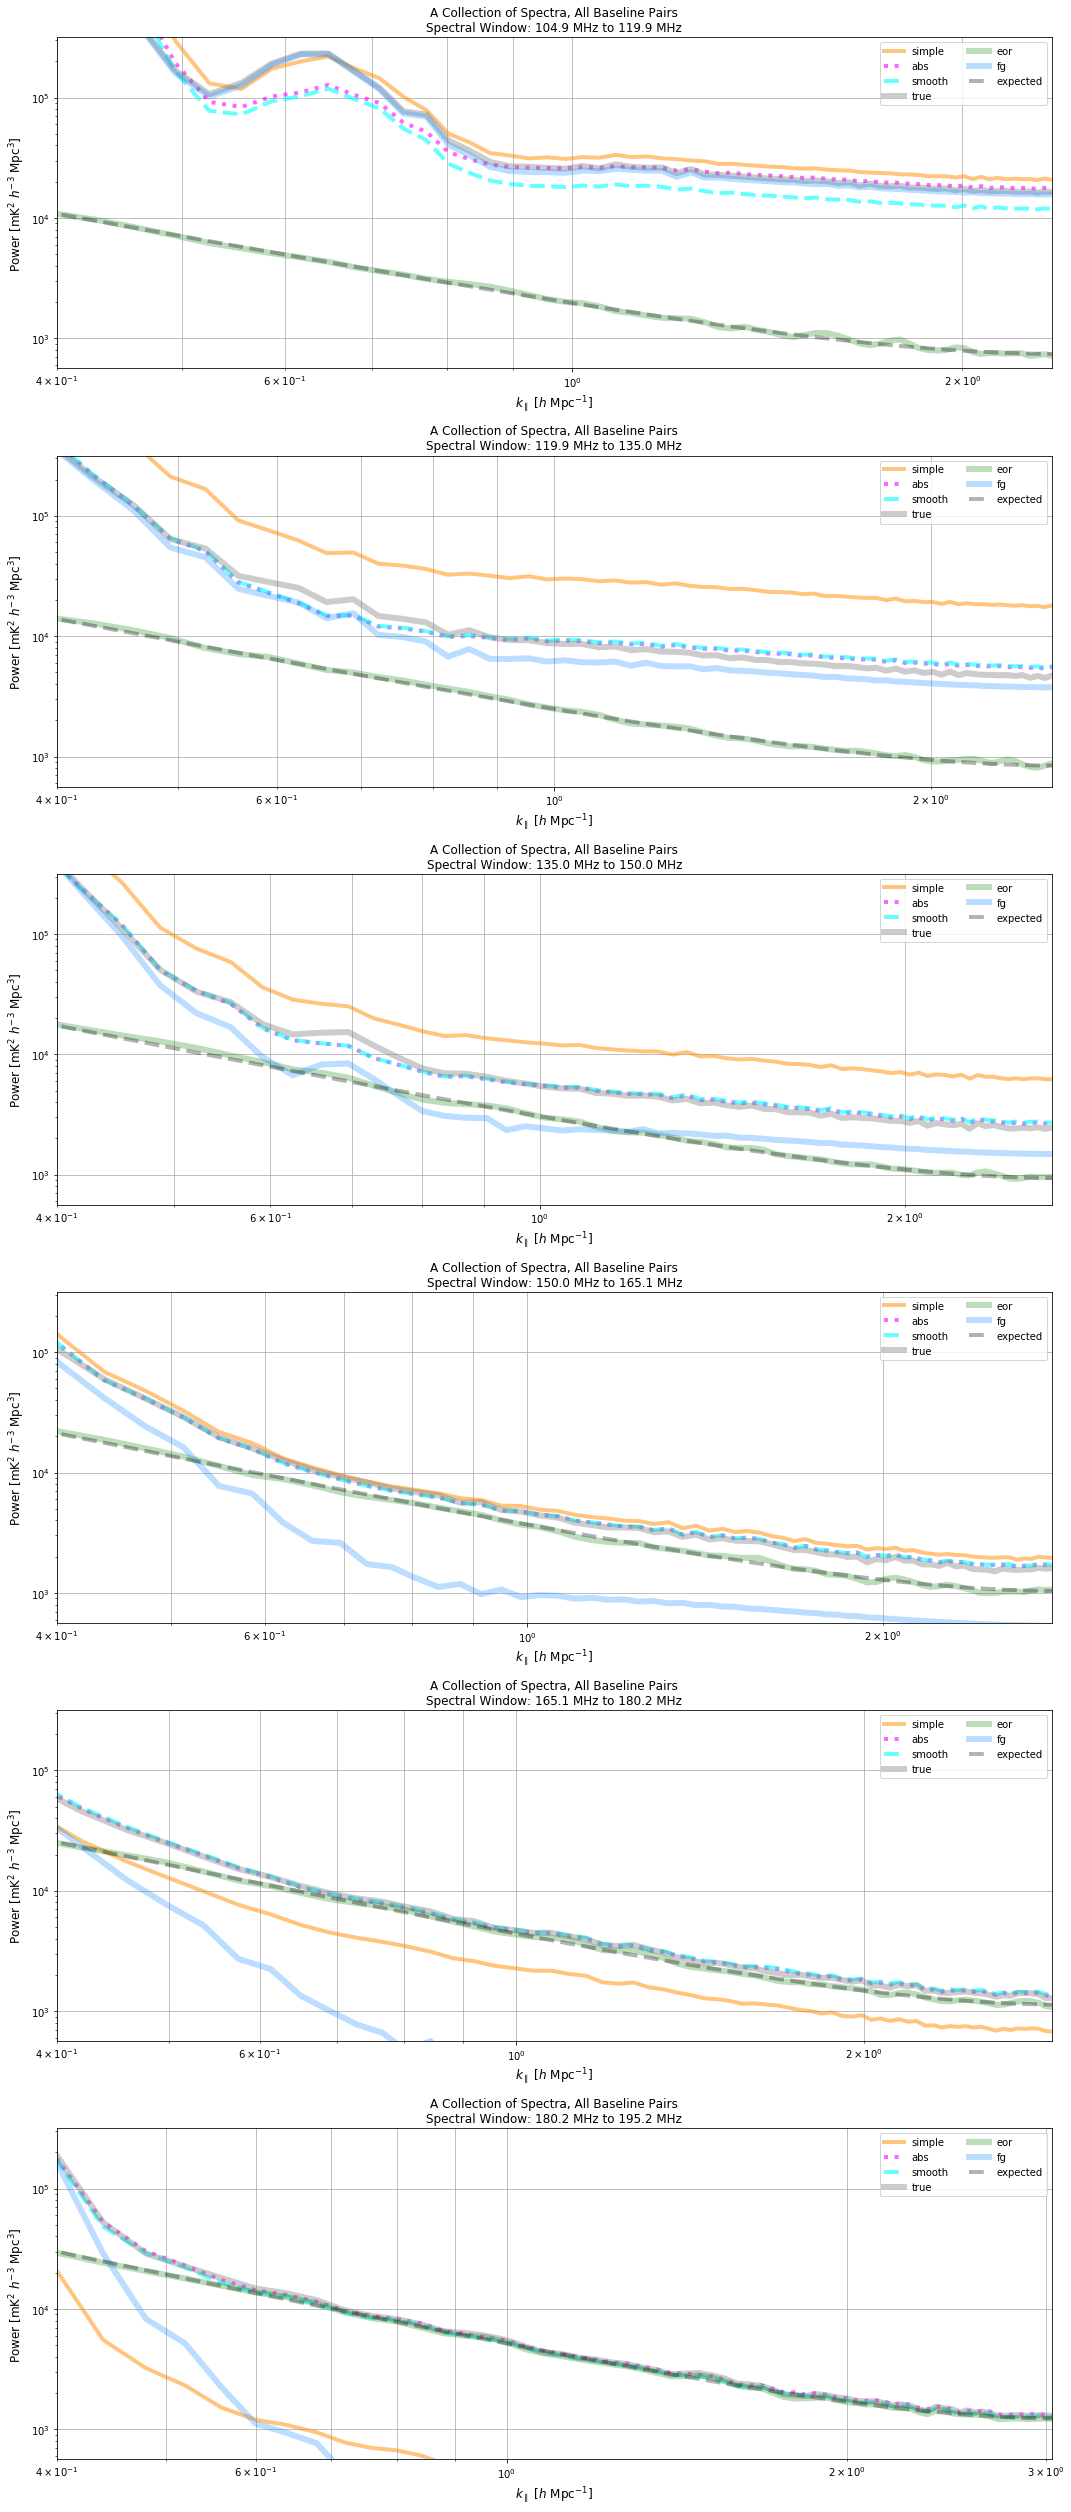

In [66]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(10**2.75, 10**5.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for spec in spec_by_spw.values():
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.asarray(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)

plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 12 |** Same plot as above, but with the viewing window restricted to $k_\parallel$ values greater than 0.4 $h$ Mpc$^{-1}$.

In [67]:
# calculate the average of the true spectrum
true_spec_bl_avg = {}
for spw, spec_dict in true_spectra.items():
    bl_avg = []
    for spec in spec_dict.values():
        bl_avg.append(spec.mean(axis=0))
    true_spec_bl_avg[spw] = np.asarray(bl_avg).mean(axis=0)

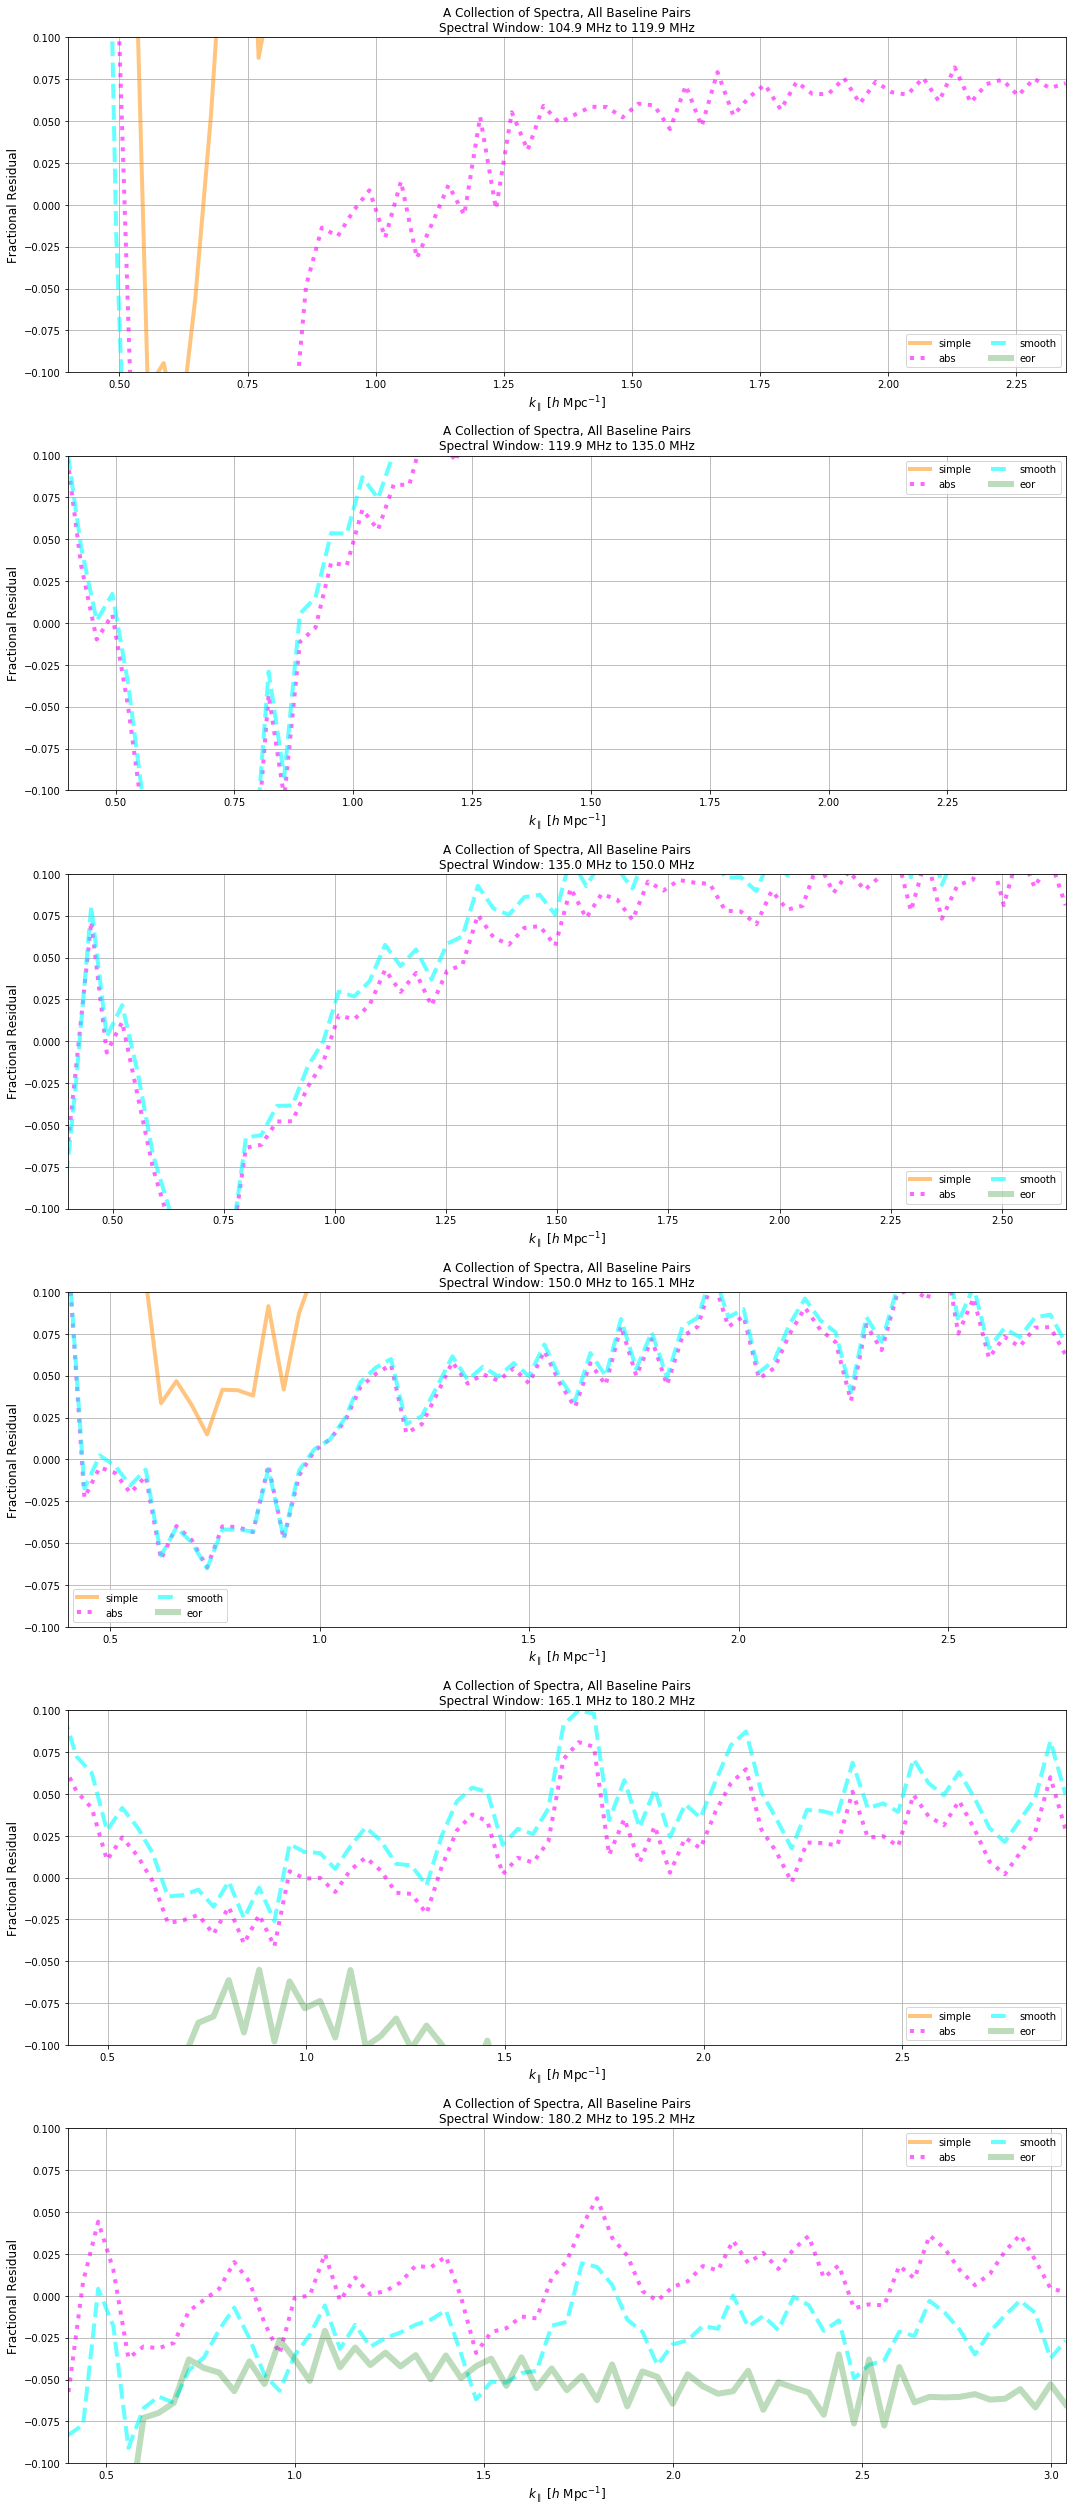

In [68]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(-0.1, 0.1)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    ax.set_ylabel("Fractional Residual", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    if label in ("fg", "true",):
        continue
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for spec in spec_by_spw.values():
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        fractional_error = np.real(bl_avg - true_spec_bl_avg[spw])
        fractional_error /= np.real(true_spec_bl_avg[spw])
        ax.plot(kparas, fractional_error, lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_residuals.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 13 |** Fractional residuals, measured relative to the true (perfectly calibrated) power spectrum estimate.

In [69]:
# memory errors keep happening around here for some reason, so delete all the spectra
del spectra, simple_cal_spectra, abs_cal_spectra, smooth_abs_cal_spectra
del omni_cal_spectra, uncal_spectra, true_spectra, eor_spectra, fg_spectra

In [70]:
# load in just the foreground spectra to show how the peak changes over spectral window
spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.fg_only.psc")))
spectra = {spw : {} for spw in range(6)}
for spec_file in spec_glob:
    psc = hera_pspec.container.PSpecContainer(spec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    for key in uvp.get_all_keys():
        spw = key[0]
        blp = key[1]
        try:
            spectra[spw][blp].append(uvp.get_data(key))
        except KeyError:
            spectra[spw][blp] = [uvp.get_data(key),]
            
# get the k_parallel array, then delete stuff
k_paras = [uvp.get_kparas(spw) for spw in range(6)]
del psc, uvp

# reformat so each entry is a numpy array
for spec_by_spw in spectra.values():
    for blp, spec in spec_by_spw.items():
        spec = np.array(spec)
        new_shape = (spec.shape[0] * spec.shape[1], spec.shape[2])
        spec_by_spw[blp] = spec.reshape(new_shape)

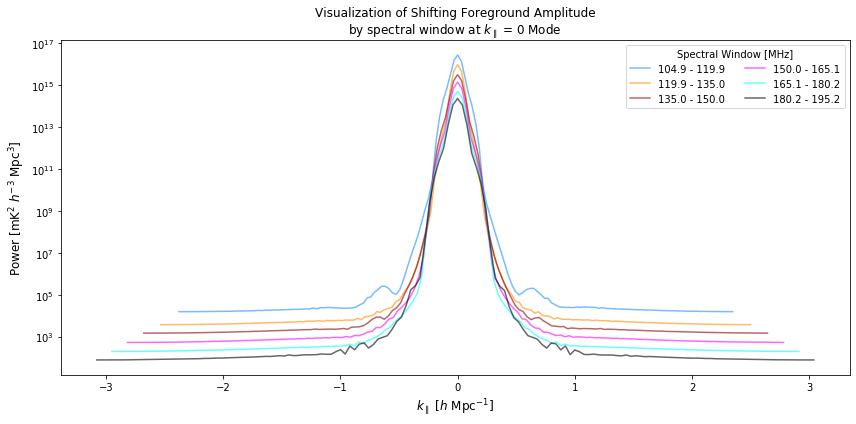

In [71]:
# now plot the stuff
colors = ("dodgerblue", "darkorange", "darkred", "magenta", "cyan", "k")
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
ax.set_title("Visualization of Shifting Foreground Amplitude\n"
             +r"by spectral window at $k_\parallel$ = 0 Mode", fontsize=12)
#ax.set_xlim(-0.5,0.5)
#ax.set_ylim(1e13,1e17)
for spw, spec_by_spw in spectra.items():
    fmin, fmax = spw_edges[spw]
    bl_avg = []
    for spec in spec_by_spw.values():
        bl_avg.append(spec.real.mean(axis=0))
    bl_avg = np.array(bl_avg).mean(axis=0)
    ax.semilogy(k_paras[spw], bl_avg, color=colors[spw], alpha=0.6, 
                label="{:4.1f} - {:4.1f}".format(fmin/1e6,fmax/1e6))
ax.legend(ncol=2, title="Spectral Window [MHz]")
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "foreground_evolution_by_spw.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 14 |** Evolution of foreground peak by spectral window. Note that the foreground peak changes by roughly 3-4 orders of magnitude over the full band.

In [72]:
# delete the spectra just to be safe
del spectra

## Frequency-Dependent EoR Amplitude

In the previous section, we found issues regarding the extraction of the expected EoR signal, likely due to issues regarding windowing and the difference in dynamic range of EoR and foregrounds. In this section, we perform the same analysis as in the previous section, but with an amplified, frequency-dependent EoR signal.

In [73]:
simple_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*simple*.psc")))
abs_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*.abs_vis.psc")))
smooth_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*smooth*.psc")))
uncal_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*uncal.psc")))
omni_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor*omni*.psc")))
true_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*freq_dep_eor.true.psc")))
eor_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.freq_dep_eor.psc")))
fg_spec_glob = sorted(glob.glob(os.path.join(spec_path_full_day, "*.fg_only.psc")))

In [74]:
globs = (simple_spec_glob, abs_spec_glob, smooth_spec_glob, uncal_spec_glob, 
         omni_spec_glob, true_spec_glob, eor_spec_glob, fg_spec_glob)

In [75]:
for spec_glob in globs:
    print(len(spec_glob))

269
269
269
269
269
269
269
269


In [76]:
%%time
# incoherently average all the spectra
# each spw has 154 channels, but we'll be folding the spectra

# initialize some dictionaries
simple_cal_spectra = {spw: {} for spw in range(6)}
abs_cal_spectra = {spw: {} for spw in range(6)}
smooth_abs_cal_spectra = {spw: {} for spw in range(6)}
omni_cal_spectra = {spw: {} for spw in range(6)}
uncal_spectra = {spw: {} for spw in range(6)}
true_spectra = {spw: {} for spw in range(6)}
eor_spectra = {spw: {} for spw in range(6)}
fg_spectra = {spw: {} for spw in range(6)}

# some stuff for making things easy
spectra = {"simple" : simple_cal_spectra,
           "abs" : abs_cal_spectra,
           "smooth" : smooth_abs_cal_spectra, 
           "uncal" : uncal_spectra,
           "omni" : omni_cal_spectra,
           "true" : true_spectra,
           "eor" : eor_spectra,
           "fg" : fg_spectra}

labels = tuple(spectra.keys())
assert len(labels) == len(globs)

skip_data = ("uncal", "omni")
#skip_data = (key for key in spectra.keys() if key != "eor")

for label, spec_glob in zip(labels, globs):
    if label in skip_data:
        continue
    spec_by_spw = spectra[label]
    for spec_file in spec_glob:
        psc = hera_pspec.container.PSpecContainer(spec_file, keep_open=False)
        uvp = psc.get_pspec(psc.groups()[0])[0]
        uvp.fold_spectra()
        for key in uvp.get_all_keys():
            spw = key[0]
            blp = key[1]
            try:
                spec_by_spw[spw][blp].append(uvp.get_data(key))
            except KeyError:
                spec_by_spw[spw][blp] = [uvp.get_data(key),]
        
# get the k_parallel arrays
k_paras = [uvp.get_kparas(spw) for spw in range(6)]

# delete the pspec container and power spectra
del psc, uvp

CPU times: user 12min 5s, sys: 3min 59s, total: 16min 4s
Wall time: 30min 18s


In [77]:
# the spectra dictionaries should have 6 spws, and each spw should have Nblp dictionaries
# each dictionary spectra[spec_file][spw][blp] should have a list with length Nfiles
# each entry in the list should have shape (10, 76)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spw in spec_dict.keys():
        for blp in spec_dict[spw].keys():
            for spec in spec_dict[spw][blp]:
                assert spec.shape == (10,76)
                
# now let's re-shape from (Nfiles, Ntimes, Ndlys) to (Nfiles * Ntimes, Ndlys)
for label, spec_dict in spectra.items():
    if label in skip_data:
        continue
    for spec_by_spw in spec_dict.values():
        for blp, spec in spec_by_spw.items():
            spec = np.array(spec)
            new_shape = (spec.shape[0] * spec.shape[1], spec.shape[2])
            spec_by_spw[blp] = spec.reshape(new_shape)
            
# in the end we have an array of shape (Nspw, Nblps, Nfiles * Ntimes, Ndlys)

In [78]:
# get the spectral window edges, k_parallel values, and delays
psc = hera_pspec.container.PSpecContainer(eor_spec_glob[0], keep_open=False)
uvp = psc.get_pspec(psc.groups()[0])[0]
uvp.fold_spectra()
spw_edges = [(spw[0], spw[1]) for spw in uvp.get_spw_ranges()]
k_paras = [uvp.get_kparas(j) for j in range(6)]
#k_paras = [uvp.get_kparas(j, little_h=False) for j in range(6)]
dlys = [uvp.get_dlys(j) for j in range(6)]

# now get the expected power spectrum for each spectral window
aliased_spectra = {}
for j, kparas in enumerate(k_paras):
    # get the frequencies in the spectral window
    spw = uvp.freq_array[j*154 : (j+1)*154] # 154 channels per spectral window
    
    # get redshift at center of spectral window
    z = cosmo.f2z(np.mean(spw))
    
    # get co-moving distances sampled along LoS
    sampled_distances = np.array([cosmo.DC(z) for z in cosmo.f2z(spw)])
    
    # convert to approximate sampling frequency
    ks_est = np.pi/np.mean(np.abs(np.diff(sampled_distances)))
    
    # calculate aliased power spectrum
    aliased_spectra[j] = aliased_power_spectrum(kparas, ks_est, z=z, cosmo=cosmo, freq_dep=True)
    
del psc, uvp

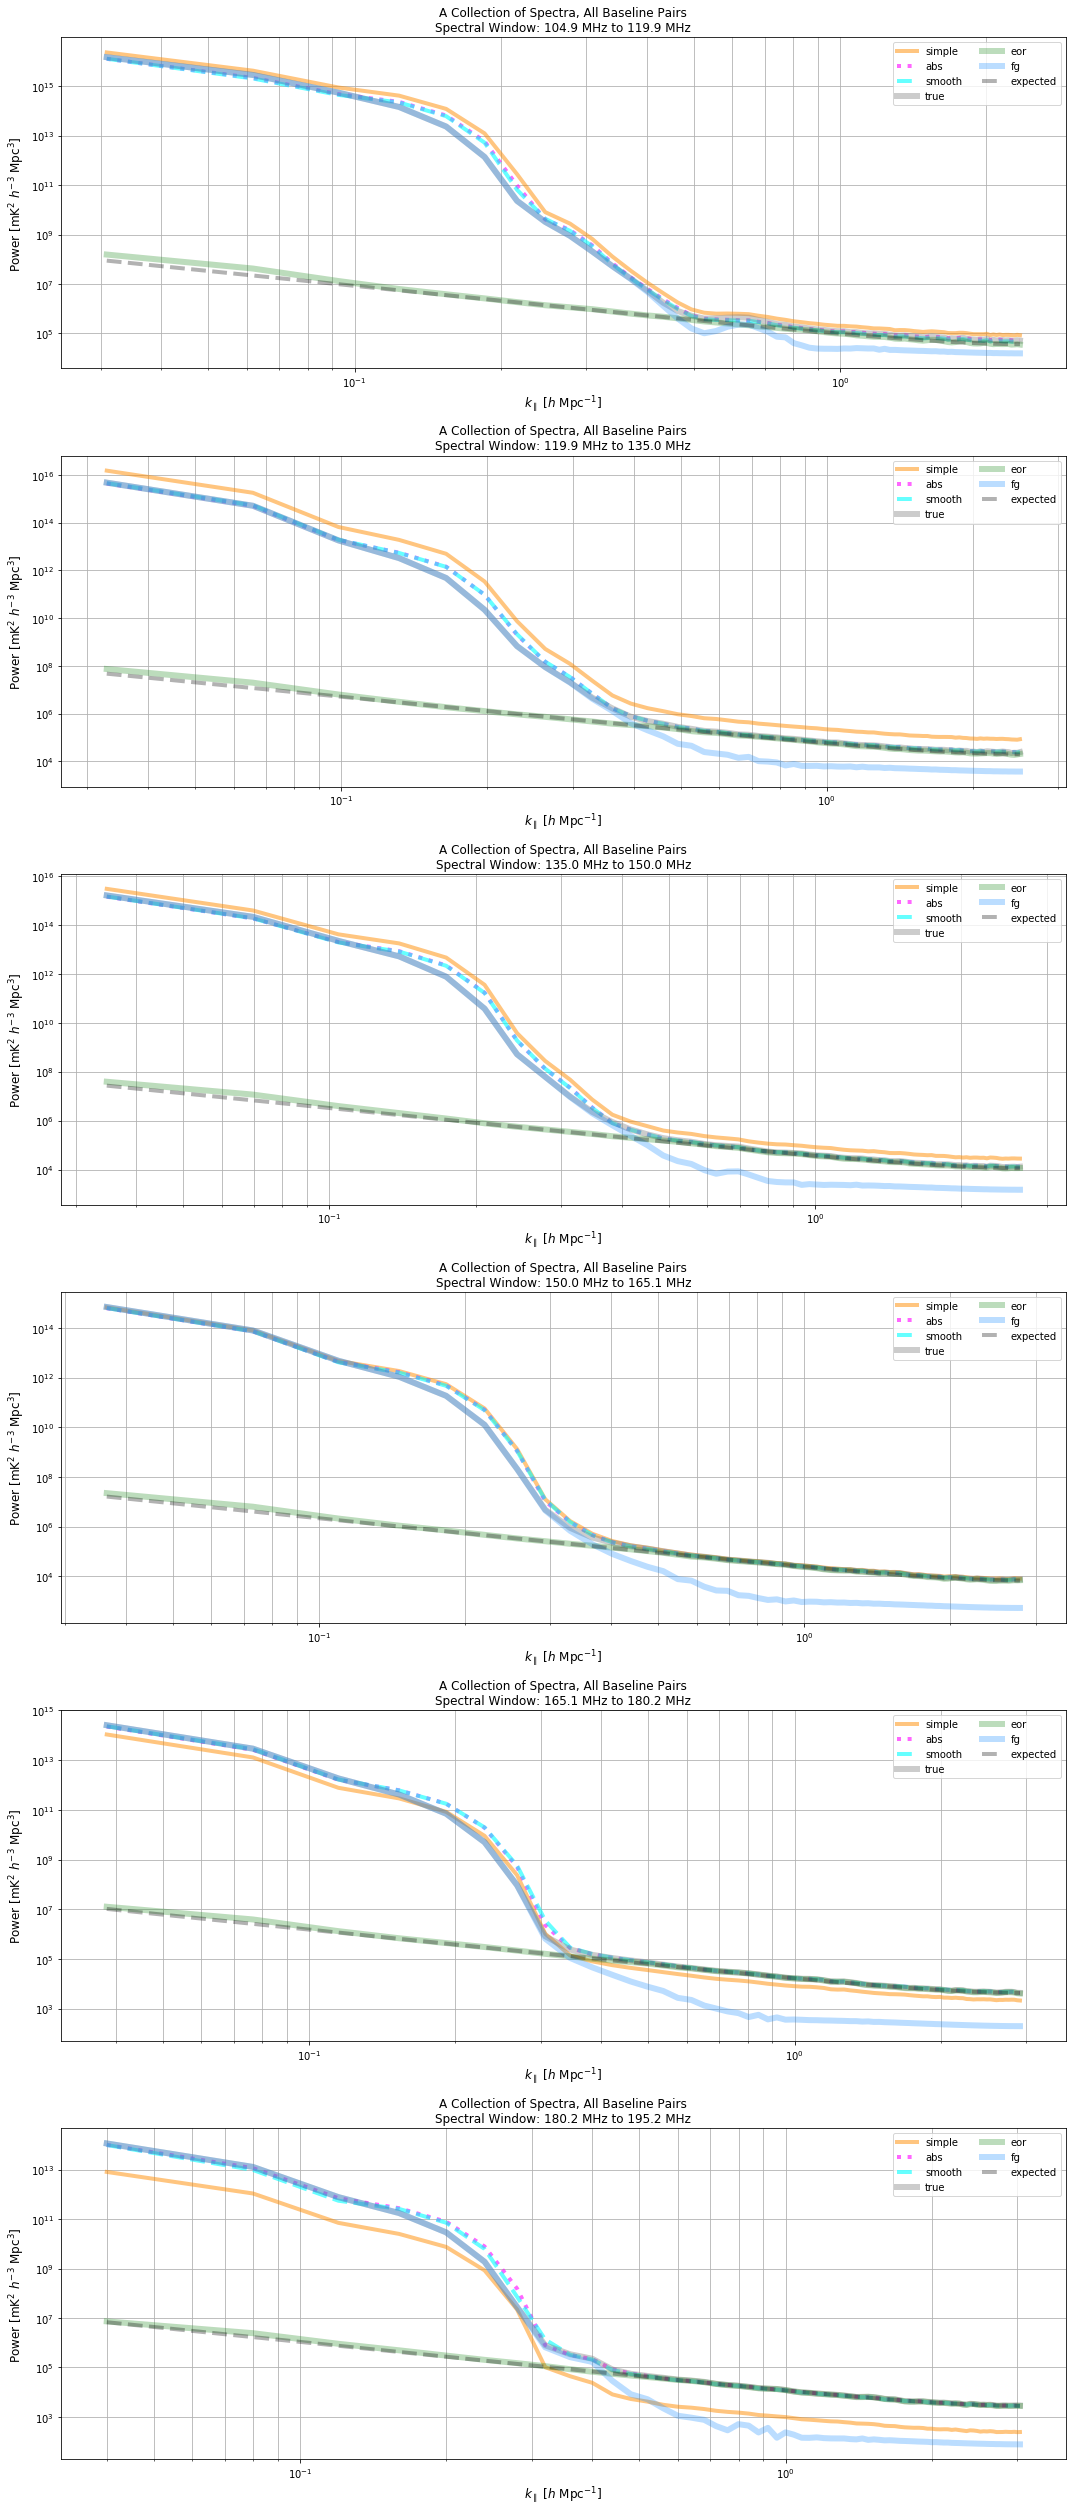

In [79]:
# for now, let's only plot the abscal, smoothed abscal, simple cal, and true power spectra
labels = ("simple", "abs", "smooth", "true", "eor", "fg")
#labels = ("eor", "fg",)
spec_to_plot = {label : spectra[label] for label in labels}
#colors = ("forestgreen", "dodgerblue",)
#alphas = (0.3, 0.3,)
#linestyles = ('-', '-',)
#lws = (6, 6,)
colors = ("darkorange", "magenta", "cyan", "gray", "forestgreen", "dodgerblue")
alphas = (0.5, 0.6, 0.6, 0.4, 0.3, 0.3)
linestyles = ('-', ':', '--', '-', '-', '-')
lws = (4, 4, 4, 6, 6, 6)

# bundle these things into an iterator
plot_iterator = lambda : zip(spec_to_plot.values(), labels, colors, alphas, linestyles, lws)

# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    #ax.set_xlim(0.4, k_paras[j].max())
    #ax.set_ylim(10**2.75, 10**5.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        #ax.semilogy(dlys[spw], np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_all_kparas_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 15 |** Same as Fig. 11, but for the boosted EoR spectrum.

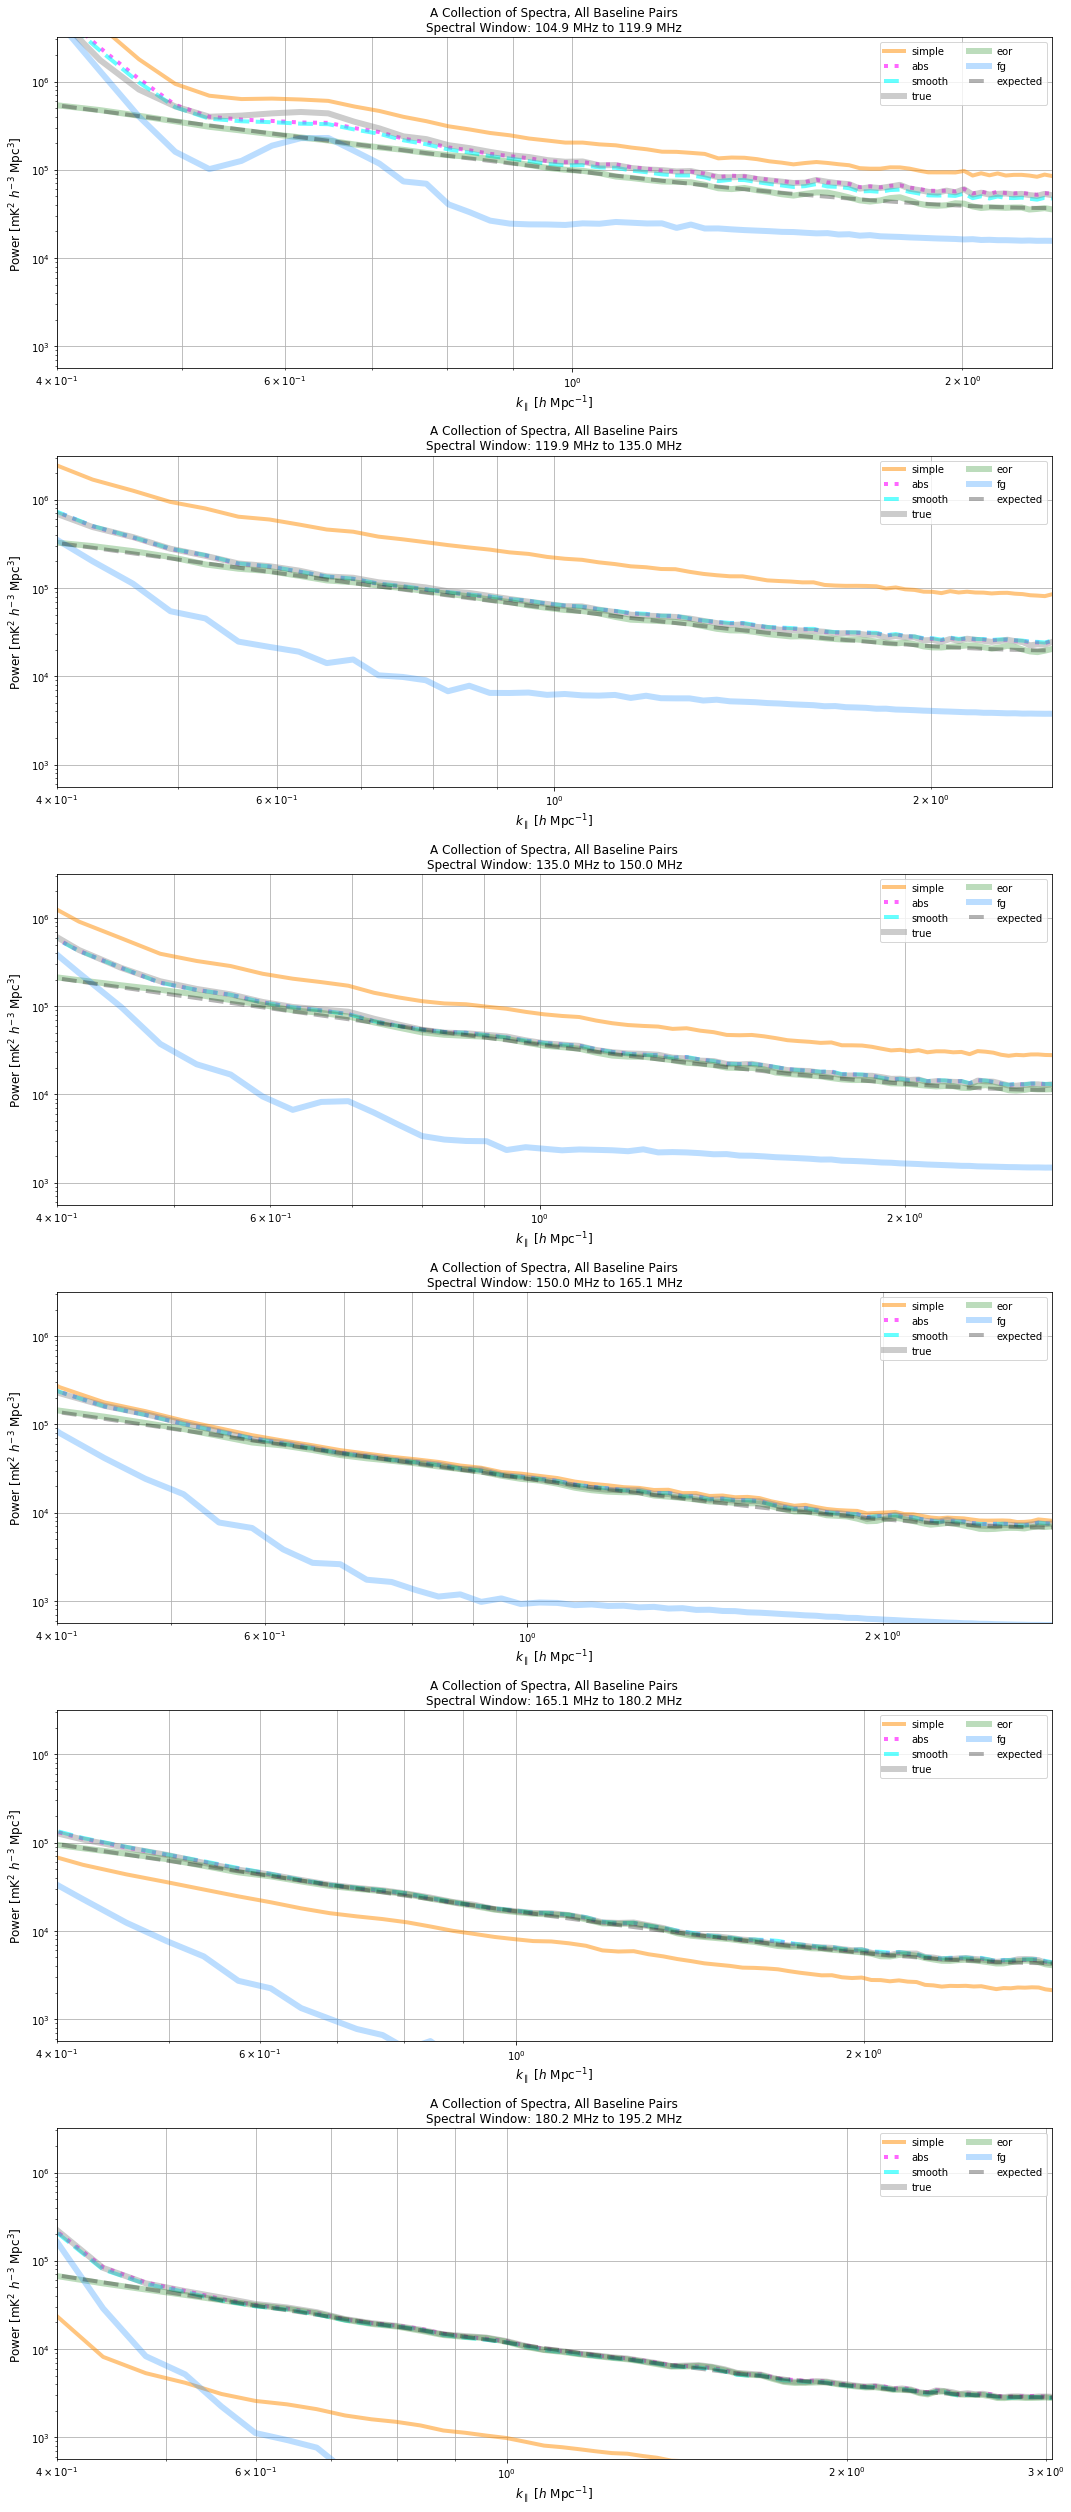

In [80]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(10**2.75, 10**6.5)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    #ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"Power [mK$^2$ $h^{-3}$ Mpc$^3$]", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.array(bl_avg).mean(axis=0)
        ax.loglog(kparas, np.abs(bl_avg), lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        
# now plot the expected power spectra
for spw, kparas in enumerate(k_paras):
    ax = axes[spw]
    ax.loglog(kparas, aliased_spectra[spw], color='k', lw=4, ls='--', alpha=0.3, label="expected")
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_with_aliased_expectation_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 16 |** Same as Fig. 12, but for the boosted EoR spectrum.

In [81]:
# calculate the average of the true spectrum
true_spec_bl_avg = {}
for spw, spec_dict in true_spectra.items():
    bl_avg = []
    for spec in spec_dict.values():
        bl_avg.append(spec.mean(axis=0))
    true_spec_bl_avg[spw] = np.asarray(bl_avg).mean(axis=0)

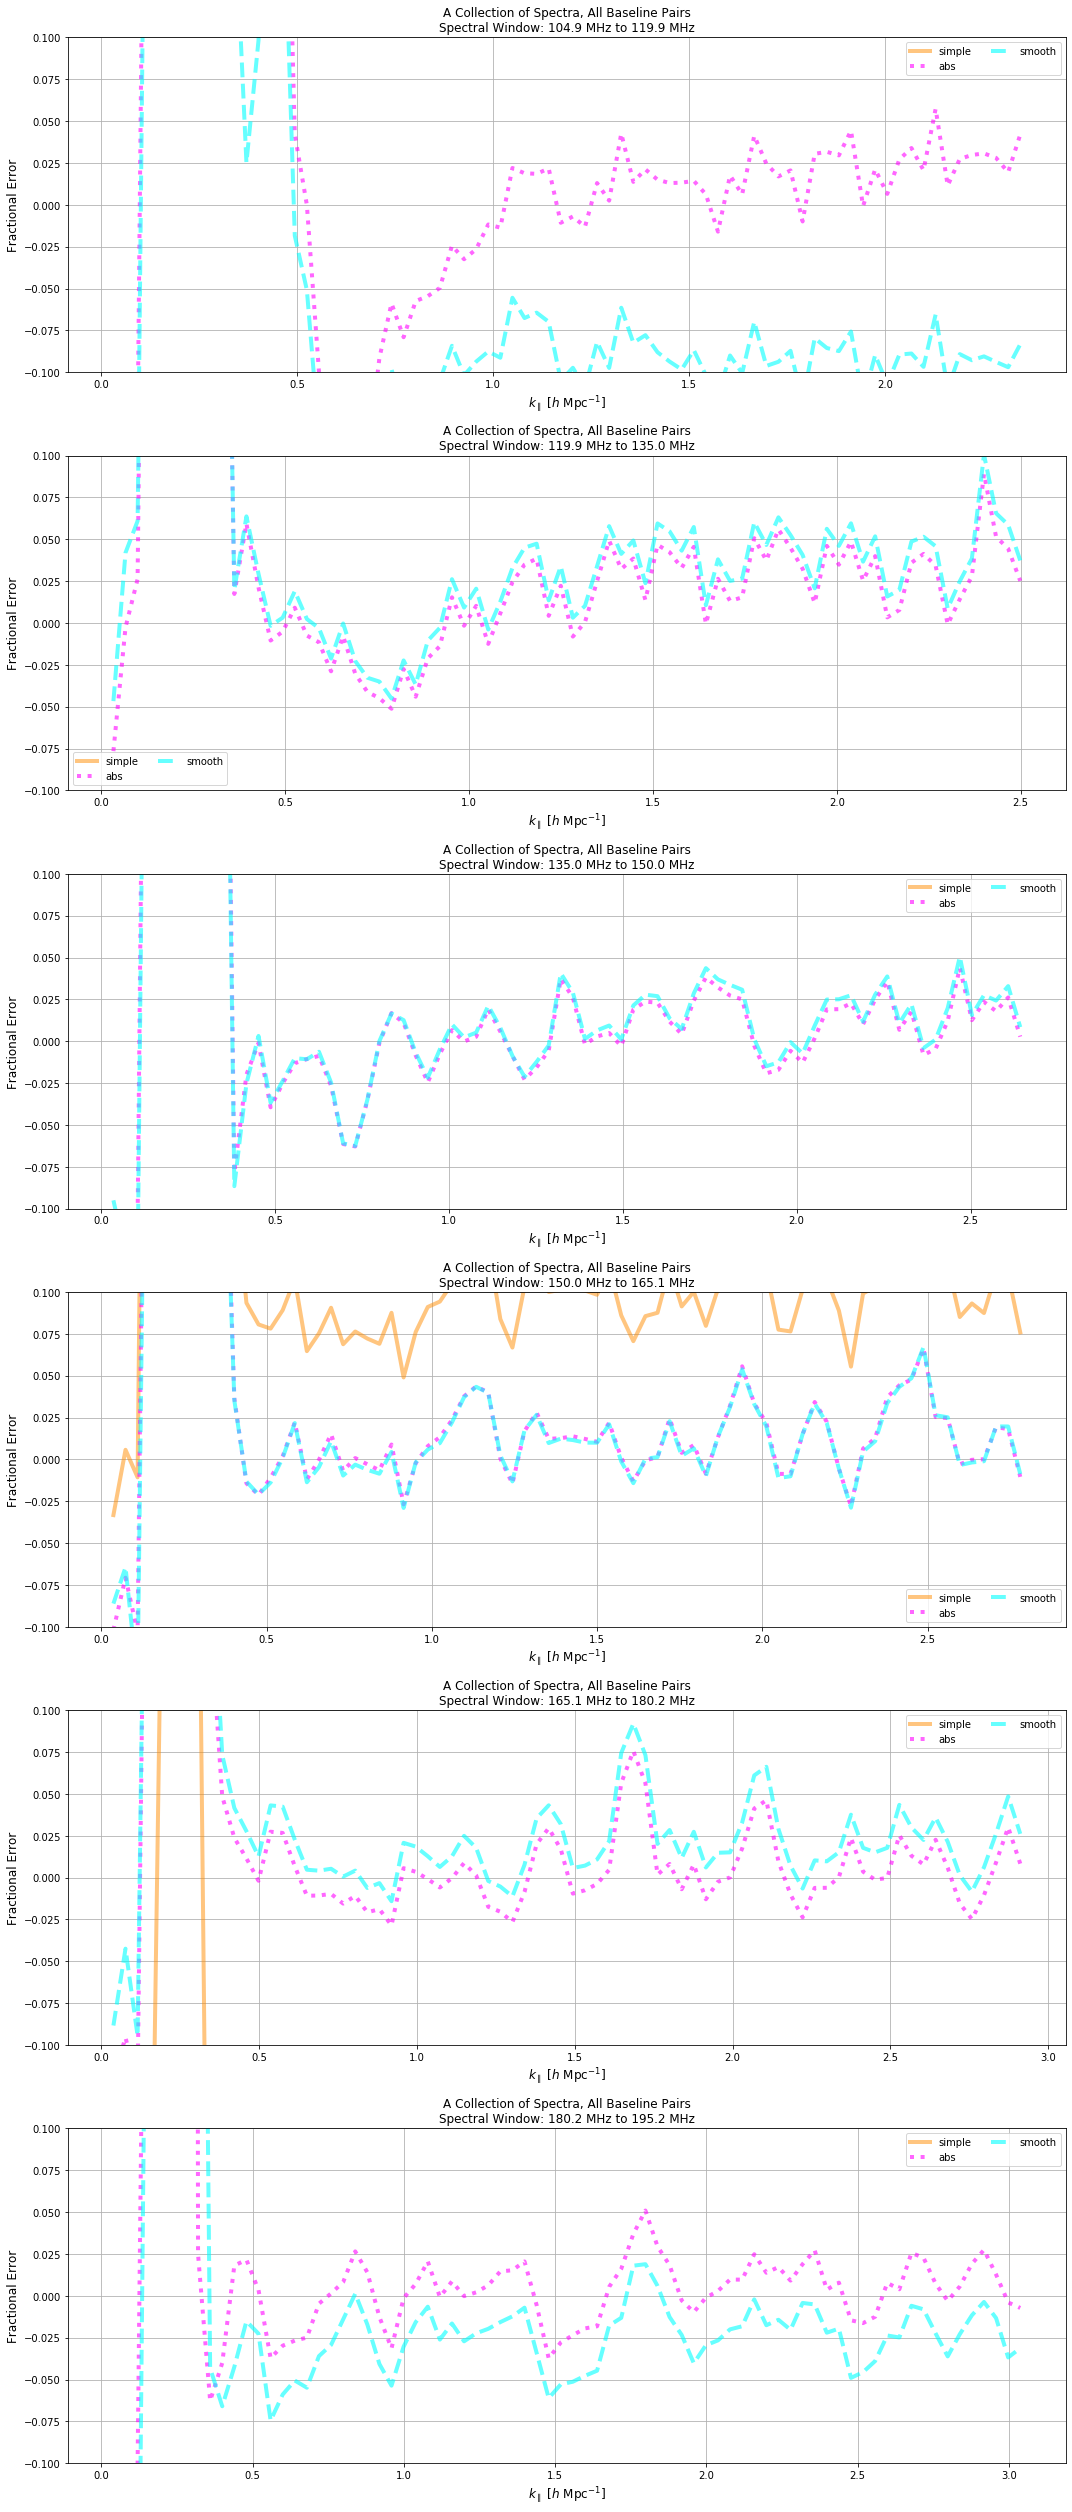

In [82]:
# create a figure and axes objects
fig = plt.figure(figsize=(15,35))
axes = fig.subplots(6)

# setup stuff
for j in range(6):
    ax = axes[j]
    #ax.set_xlim(0.4, k_paras[j].max())
    ax.set_ylim(-0.1, 0.1)
    ax.grid(b=True, which="major", axis="y")
    ax.grid(b=True, which="both", axis="x")
    fmin, fmax = spw_edges[j]
    ax.set_title("A Collection of Spectra, All Baseline Pairs\n" + \
                  "Spectral Window: {:4.1f} MHz to {:4.1f} MHz".format(fmin/1e6, fmax/1e6),
                  fontsize=12)
    ax.set_xlabel(r"$k_\parallel$ [$h$ Mpc$^{-1}$]", fontsize=12)
    ax.set_ylabel("Fractional Error", fontsize=12)
    
# plot all the ("measured") things    
for spec_dict, label, color, alpha, ls, lw in plot_iterator():
    if label in ("fg", "true", "eor",):
        continue
    for spw, kparas in enumerate(k_paras):
        ax = axes[spw]
        spec_by_spw = spec_dict[spw]
        bl_avg = []
        for blp, spec in spec_by_spw.items():
            #ax.loglog(kparas, np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            #ax.semilogy(dlys[spw], np.abs(spec.mean(axis=0)), marker='o', ms=2, color=color, alpha=0.3, lw=0)
            bl_avg.append(spec.mean(axis=0))
        bl_avg = np.asarray(bl_avg).mean(axis=0)
        fractional_error = (np.real(bl_avg) - np.real(true_spec_bl_avg[spw]))
        fractional_error /= np.real(true_spec_bl_avg[spw])
        ax.plot(kparas, fractional_error, lw=lw, ls=ls, color=color, alpha=alpha, label=label)
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()
save_path = os.path.join(plot_path, "full_day_residuals_freq_dep_eor.pdf")
fig.savefig(save_path)
fig.savefig(save_path.replace(".pdf", ".png"))

**Figure 17 |** Plot of the fractional residuals of power spectra, measured relative to the true (perfectly calibrated) power spectrum estimate.

In [83]:
# include some sort of summary statistics: mean fractional difference over entire spw;
# mean fractional diff over spw with k > 0.5; etc

In [95]:
del spectra, simple_cal_spectra, abs_cal_spectra, smooth_abs_cal_spectra
del omni_cal_spectra, uncal_spectra, true_spectra, eor_spectra, fg_spectra